Вы можете использовать этот блокнот в Colab. В этом случае, загрузите файлы каналов на Google Drive, установите ```USE_GOOGLE_DRIVE = True``` и заполните путь ```FOLDER_PATH``` к папке с файлами каналов.
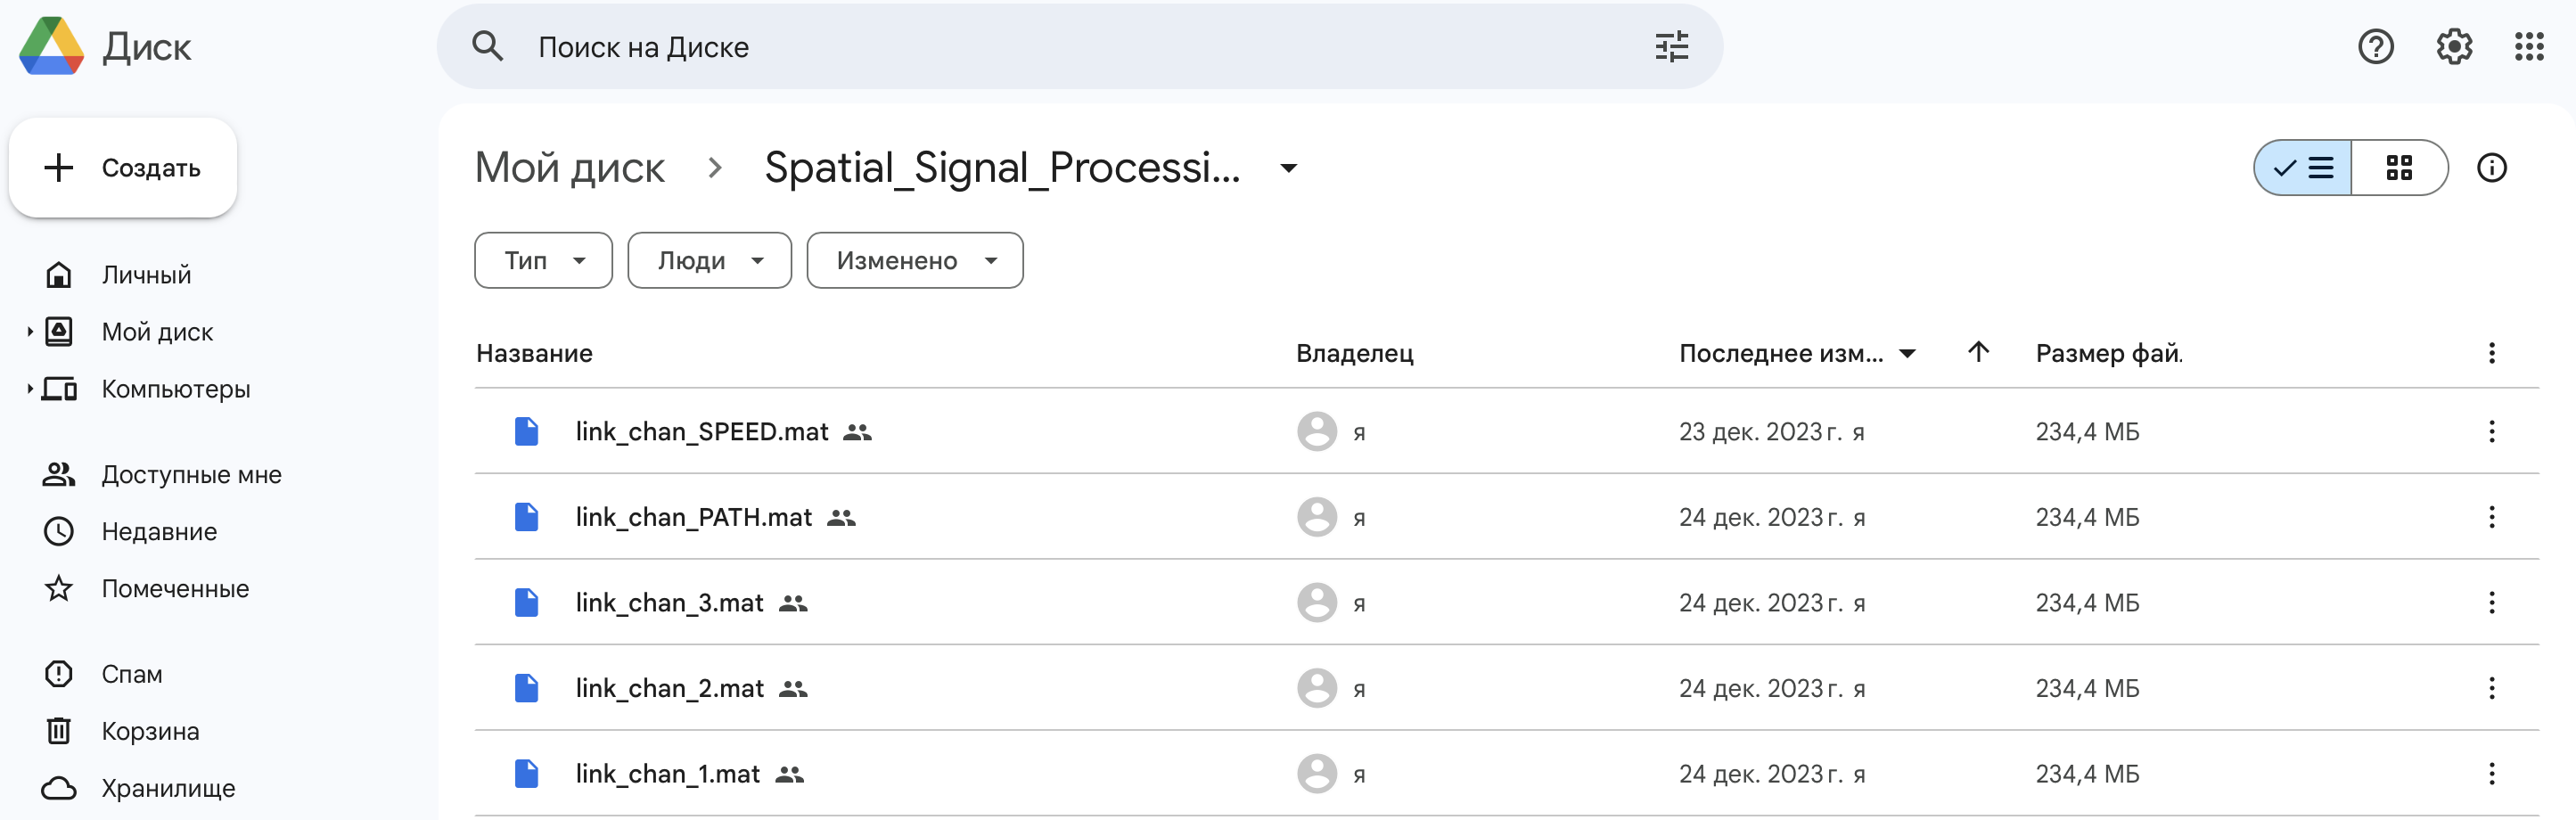


Также, вы можете использовать этот ноутбук на локальном устройстве, установив ```USE_GOOGLE_DRIVE = False``` и заполнив переменную ```FOLDER_PATH``` с расположением файлов на локальном устройстве.

In [1]:
# Install modulation library
!pip install -q ModulationPy

In [2]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
from ModulationPy import PSKModem, QAMModem
from tqdm.notebook import tqdm, trange
from numpy import sqrt
import functools
plt.rcParams.update({'font.size': 15})

USE_GOOGLE_DRIVE = False
FOLDER_PATH = '/home/lexotr/my_gits/9_semester_programming/mimo/first_hw/Channels'

# Which channel file you'd like to load
CHAN_NAME = 'link_chan_{}.mat'.format('2')

if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/gdrive')
    CHAN_NAME = 'link_chan_{}.mat'.format('2')

os.chdir(FOLDER_PATH)

Давайте загрузим файл канала.
Мы видим, что наш канал — это тензор $\mathcal{H} \in \mathbb{C}^{M \times N \times K \times T}$, где

$M — $Количество антенн на стороне пользователя (UE)

$N — $Количество антенн на стороне базовой станции (BS)

$K — $Количество поднесущих, используемых для передачи данных

$T — $Количество моментов времени, когда измерялся канал

Теперь давайте построим график амплитуд и фаз в частотной области между фиксированной парой антенн для фиксированного момента времени:

Number of user antennas:  4
Number of base station antennas:  64
Number of subcarriers:  256
Number of time moments:  100


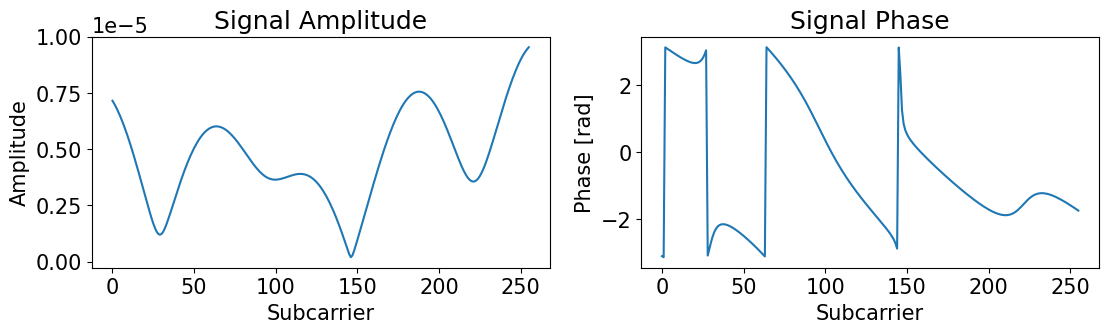

In [3]:
H = scipy.io.loadmat(CHAN_NAME)['Link_Channel'][:,:,:256,:]

N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape

# Some info about signal
print('Number of user antennas: ', N_ue_ants )
print('Number of base station antennas: ', N_bs_ants)
print('Number of subcarriers: ', N_subcarriers)
print('Number of time moments: ', N_tti)

# Let's plot Amplitudes and Phases over frequencies for fixed pair of antennas
# and fixed time moment (TTI)
plt.figure(figsize = (13,3))
plt.subplot(1,2,1)
plt.plot(np.abs(H[0,0,:,0]))
plt.title('Signal Amplitude'); plt.xlabel('Subcarrier'); plt.ylabel('Amplitude')

plt.subplot(1,2,2)
plt.plot(np.angle(H[0,0,:,0]))
plt.title('Signal Phase'); plt.xlabel('Subcarrier'); plt.ylabel('Phase [rad]')
plt.show()

# Изучение влияния пространственного согласующего фильтра (ПСФ) в канале MIMO:

Из лекций вы можете вспомнить различные схемы *предварительного кодирования*, которые являются методом обработки сигнала для антенных решеток для направленной передачи или приема сигнала. В этой части мы хотели бы оценить преимущества использования схем предварительного кодирования для передачи сигналов в условиях аддитивного белого гауссовского шума (AWGN). Для этого давайте построим наш простейший симулятор MIMO и смоделируем передачу сигнала с различными уровнями шума или *соотношениями сигнал/шум* (SNR). Что касается метрики, мы будем использовать *коэффициент ошибок по битам* (BER), который можно понимать как вероятность того, что бит будет правильно распознан на стороне приемника.


In [4]:
def bit_error_rate(received_bits, true_bits):
    '''Calculates bit error rate (BER) between two-bit sequences'''

    return np.mean(np.abs(received_bits - true_bits), axis = 1)


def get_noise(signal, SNR_dB):
    '''Returns complex AWGN tensor for a signal with the same shape
       satisfying SNR ratio
        Inputs:
            - signal: (np.ndarray) some signal array
            - SNR: (int) SNR value in decibels, which adjusts noise power.
                    if SNR is None, return 0 (no noise at all)
       '''
    if SNR_dB is None:
        return 0
    # complex-valued AWGN with 0 mean and unit variance with same size as @signal
    noise = np.sqrt(1/2) * (np.random.randn(*signal.shape) + 1j*np.random.randn(*signal.shape))

    # Calculate mean @signal power
    P_signal = np.mean(np.abs(signal)**2)

    # Normalize Noise to satisfy SNR
    noise_normed = noise * sqrt(10**(-SNR_dB/10) * P_signal)
    return noise_normed

Другим важным аспектом моделирования канала AWGN является нормализация канала. Обычно бо'льшая часть шума появляется на стороне приемника. Для правильного квантования устройство *автоматической регулировки усиления* обычно нормализует принимаемый сигнал, чтобы зафиксировать амплитуду или мощность сигнала. Предположим, что мы хотим получить единичную мощность для каждой антенны RX.
Чтобы добиться этого, мы можем нормализовать каждый срез, чтобы удовлетворить:

$$\| H_{rx} \|^2_F = \sum_{m=1}^{M}\sum_{k=1}^{K} |H(m,k)|^2 = M$$

Где $H_{rx} \in \mathbb{C}^{M \times K} -$ матрица принятого канала для любой антенны базовой станции и момента времени, а $\| \cdot \|_F$ — норма Фробениуса.

In [5]:
def normalize(H):
    '''
    Normalizes the channel along UE antennas and subcarriers to have unit power on each receive antenna.
    '''
    # Shape of H
    N_ue, N_bs, N_f, N_tti = H.shape

    # Calculate norms along 0,2 axis (N_ue, N_f)
    norma = np.linalg.norm(H, ord = 'fro', axis = (0,2), keepdims = True)

    # return normalized channel
    H_normed = H / norma * sqrt(N_ue)
    return H_normed

Давайте создадим пошаговую симуляцию передачи и приема данных MIMO. Для начала нам нужно создать последовательность битов, которая должна быть передана. Это можно легко сделать следующим образом:

In [6]:
bits = np.random.binomial(n = 1, p = 0.5, size = N_subcarriers)
print(bits)

[1 1 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1
 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0
 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1
 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0
 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0
 0 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1
 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0]


Однако мы можем захотеть увеличить количество бит, отправляемых каждым символом, а также мы хотели бы перенести биты из компьютерного представления в физическое, такой процесс называется модуляцией. Для модуляции и демодуляции сигналов мы можем использовать библиотеку ModulationPy, или вы можете реализовать ее [самостоятельно](https://www.nrexplained.com/modulation). В этой работе мы рассмотрим использование BPSK, QPSK, 16QAM и других модуляций M-QAM.
Давайте рассмотрим использования модулятора на примере:

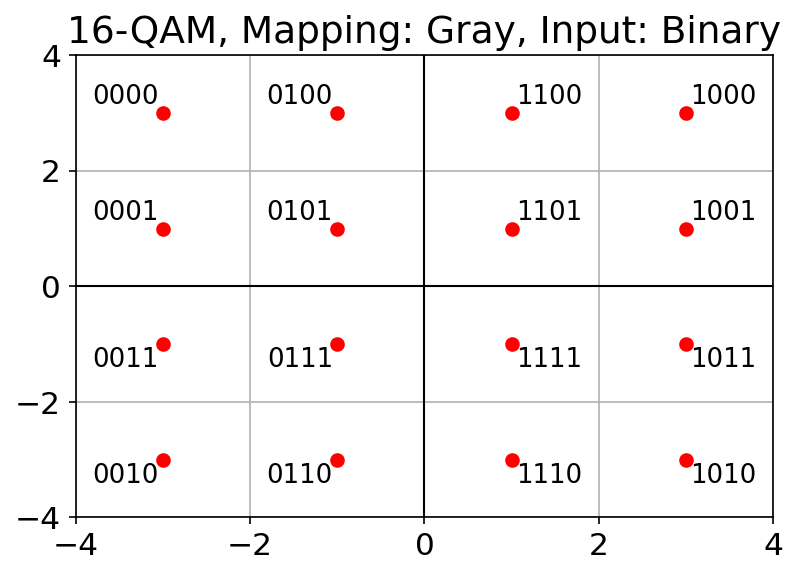

In [7]:
N_constellation_points = 16 # 16QAM modulation

# How many bits we can send using defined number of constellation points
N_bits_per_conts_point = int(np.log2(N_constellation_points))

modem = QAMModem(M = N_constellation_points,
                 bin_input = True,              # it will use bits as input
                 gray_map = True,               # reorder constellation points to have unit distance between neigbours
                 soft_decision = False,         # hard detector for detection
                 bin_output = True)             # demodulate signal to bits
modem.plot_const()


Также нам необходимо добавить нормализацию точек созвездия, чтобы удовлетворить тому факту, что ожидание по мощности всех символов равно 1: $\mathbb{E}(|s|^2) = 1 $

In [8]:
# For each subcarrier transform N_bits_per_conts_point bits into one QAM symbol
bits = np.random.binomial(n = 1, p = 0.5, size = ( N_subcarriers, N_bits_per_conts_point))

# Normalization constant. Dont forget to denormalize signal before decoding!
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

# Create 1 OFDM symbol with N_subcarriers QAM symbols.
qam_symbols = modem.modulate(bits.flatten()).reshape(N_subcarriers) / constellation_norm

# Print some symbols and check the normalization
print('S size: ',qam_symbols.shape, end = '\n\n')
print('Some symbols : ',qam_symbols[:15], end = '\n\n')
print('Expectation is', np.mean(np.abs(qam_symbols)**2))

S size:  (256,)

Some symbols :  [ 0.9486833 +0.9486833j  -0.31622777-0.31622777j -0.31622777+0.31622777j
 -0.9486833 +0.31622777j  0.9486833 +0.9486833j  -0.31622777-0.31622777j
 -0.9486833 -0.9486833j  -0.9486833 -0.31622777j -0.31622777+0.31622777j
 -0.31622777+0.31622777j  0.9486833 -0.9486833j  -0.9486833 -0.31622777j
 -0.9486833 -0.9486833j   0.31622777+0.9486833j  -0.31622777+0.9486833j ]

Expectation is 1.0187499999999998


Теперь нам нужно передать этот сигнал с помощью $N$ антенн, поэтому мы отображаем сгенерированный сигнал на антенны с разными фазовыми сдвигами. Здесь уже реализован равномерный прекодер. Уравнение для такого типа прекодера:
$$ \mathop{\mathrm{P(k,t)}}_{N\times 1} = \sqrt{\frac{1}{N}}
\begin{bmatrix}
1 \\
\dots \\
1 \\
\end{bmatrix}
$$
Предполагается, что это базовое решение, которое не использует никаких пространственных свойств систем MIMO.

Здесь нам нужно реализовать прекодер SVD с использованием матрицы каналов. Для расчета такого прекодера мы используем ранее оцененный канал. Его можно факторизовать с помощью разложения по сингулярным значениям (SVD) следующим образом:
$$
\mathop{\mathrm{H}(k,t)}_{M \times N} = \mathop{\mathrm{U}(k,t)}_{M \times M} \mathop{\mathrm{\Sigma}(k,t)}_{M \times N}\mathop{\mathrm{V}^H(k,t)}_{N \times N}
$$
Здесь $\mathrm{U}$ и $\mathrm{V}^H$ содержат ортогональные векторы. Нас интересуют векторы из $\mathrm{V}^H$, которые связаны с сингулярными значениями с самыми высокими амплитудами. Таким образом, для однопоточной передачи наш прекодер — это вектор ${ N\times 1}$ для каждой поднесущей $k$ и момента времени $t$


In [9]:
def get_precoder(H, rank, precoder_type = 'uniform'):
    '''
    Calculates precoder with given parameters
    Inputs:
        - H (np.ndarray) is channel matrix with shape of [N_ue_ants x N_bs_ants x N_subcarriers]
        - rank (int) is number of bit-stereams which we want to precode
        - precoder_type (str) : flag, which precoder type to use
          if precoder_type='uniform' precoder is normalized unit vector (baseline)
          if precoder_Type='svd' uses Vh singular vectors as precoder (SHOULD BE IMPLEMENTED)
    Returns:
        - precoder (np.ndarray) with shape of [N_bs_ants x rank x N_subcarriers]
    '''

    N_ue, N_bs, N_f = H.shape

    precoder = np.zeros((N_bs, rank, N_f), dtype = np.complex128)

    # here we calculate SVD precoder. Your task to implement it
    if precoder_type == 'svd':
        # print(f"old {H.shape}")
        # print(f"new {np.transpose(H, (2, 0, 1)).shape}")
        U, Sigma, V_t = np.linalg.svd(np.transpose(H, (2, 0, 1)))
        # print(f"old shapes: {U.shape}, {Sigma.shape}, {V_t.shape}")
        # print(V_t.shape)
        precoder = V_t[...,:rank, :]
        # print(f"got : {precoder.shape}")
        precoder = np.conj(np.transpose(precoder, (2, 1, 0))) # the vectors are in rows
        # print(f"after transpose : {precoder.shape}")
    # here we calculate uniform precoder
    elif precoder_type == 'uniform':
        assert rank == 1  # impossible to use other ranks

        # for each subcarrier
        for subc in range(N_f):
            # precoder norm must be 1
            precoder[..., subc] = np.ones((N_bs, rank)) / (np.sqrt(N_bs * rank));

    return precoder

In [10]:
# Precoder testing

# Fix channel for some time moment
t = 0
Ht = H[..., t]

# Calculate precoder
precoder = get_precoder(H = Ht, rank = 1, precoder_type = 'uniform')
test =  get_precoder(H = Ht, rank = 2, precoder_type = 'svd')
print(test.shape)

print('precoder shape: ', precoder.shape)
print('precoder power per subcarrier: ', np.sum(np.abs(precoder)**2)/N_subcarriers)

(64, 2, 256)
precoder shape:  (64, 1, 256)
precoder power per subcarrier:  1.0


Теперь создадим предварительно кодированный передаваемый сигнал $\mathrm{X}$:
$$ \mathop{\mathrm{X}}_{N\times1}(k,t) = \mathop{\mathrm{P}(k,t)}_{N\times l} \hspace{0.3em} \mathop{\mathrm{s(k,t)}}_{l\times 1} $$
Здесь $l$ — количество битовых потоков (`rank` в функции прекодера)

In [11]:
def transmitter_signal(s_signal, precoder):
    '''
    Forms transmitter signal using modulated data and precoder
    Inputs:
        - s_signal: (np.ndarray) streams of modulated symbols with shape of [rank x 1 x N_subcarriers]
        - precoder: (np.ndarray) precoder with shape of [N_bs_ants x rank x N_subcarrires]
    Output:
        - X: (np.ndarray) transmitted precoded signal with shape of [N_bs_ants x N_subcarriers]
    '''

    N_bs, rank, N_f = precoder.shape
    if len(s_signal.shape) < 3:
        s_signal = np.expand_dims(s_signal, 1)
    X = np.zeros((N_bs, N_f), dtype = np.complex128)
    # print(precoder.shape)
    # print(s_signal.shape)
    # print(X.shape)

    # calculate independently for each subcarrier
    # ---------------------------------------------------------------------------------------
    # Your code here

    X = np.einsum('PAN,ABN ->PBN', precoder, s_signal)
    X = np.squeeze(X, 1)
    # print(precoder[..., 0])
    # print(s_signal[0,0])
    # print(X[..., 0])
    # ---------------------------------------------------------------------------------------

    return X

In [12]:
# print information about TX signal
X = transmitter_signal(s_signal = qam_symbols[None,:], precoder = precoder)
print('TX signal shape:', X.shape)
print('TX signal power: ', np.sum(np.abs(X)**2))
print(f'TX signal: {np.sum(np.abs(qam_symbols[None,:])**2)}')

TX signal shape: (64, 256)
TX signal power:  260.79999999999995
TX signal: 260.79999999999995


Теперь мы хотели бы смоделировать полученный сигнал $y$ на каждой поднесущей путем умножения матрицы канала на переданный вектор сигнала. Кроме того, полученный сигнал искажен шумом. Знаменитое уравнение для полученного сигнала можно записать следующим образом

$$
\mathop{\mathrm{y(k,t)}}_{M \times 1} = \mathop{\mathrm{H(k,t)}}_{M \times N} \mathop{\mathrm{x(k,t)}}_{N \times 1} + \mathop{\mathrm{n(k,t)}}_{M \times 1}
$$

In [13]:
def receiver_signal(H, X, SNR_dB):
    '''
    Model signal at the receiver side. Returns received signal with noise is SNR_dB is int.
    If SNR_dB is None - returns ideal signal
    INPUTS:
        - H (np.ndarray): channel tensor with shape of [N_ue_ants x N_bs_ants x N_subcarrier]
        - X (np.ndarray): transmitted signal matrix with shape of [N_bs_ants x N_subcarrier]
        - SNR_dB (int or None): Signal to Noise ratio in decibels.

    '''
    N_ue, N_bs, N_f = H.shape

    y = np.zeros((N_ue, N_f), dtype = np.complex128)

    # ---------------------------------------------------------------------------------------
    # Your code here

    if len(X.shape) == 2:
        X = np.expand_dims(X, 1)
    result = np.einsum("MBN,BAN->MAN", H, X)
    y = np.squeeze(result, 1)

    # H_rolled = np.rollaxis(H, 2)
    # x_rolled = np.expand_dims(np.rollaxis(X, 1), 2)
    # print(f"rooeld H: {H_rolled.shape}")
    # print(f"rooeld x: {x_rolled.shape}")
    # y_rolled = np.squeeze(np.matmul(H_rolled, x_rolled), 2)
    # print(f"rooeld y: {y_rolled.shape}")
    # y_compare = np.rollaxis(y_rolled, 1)
    # print(f"res: {y.shape}")
    # print(f"res: {np.allclose(y_compare, y)}")
    # ---------------------------------------------------------------------------------------

    N = get_noise(np.mean(H, 1) * sqrt(N_bs), SNR_dB)
    # N = get_noise(y, SNR_dB)
    return y + N

In [14]:
# Check received signal and SNR
# define SNR value
SNR = -10

# Obtain ideal signal without noise
Y_ideal = receiver_signal(Ht, X, None)

# Obtain signal with noise
Y_noisy = receiver_signal(Ht, X, SNR)

# Get noise tensor
Noise = Y_noisy - Y_ideal

# Calcualte mean ideal signal Power
Signal_power_dB = 10 * np.log10( np.mean( np.abs(Y_ideal)**2 ))

# Calculate mean noise Power
Noise_power_dB = 10 * np.log10( np.mean( np.abs(Noise)**2 ))

# Check SNR value
print('SNR: ', Signal_power_dB - Noise_power_dB, 'dB')


SNR:  -9.790667932620295 dB


Теперь мы хотели бы получить последовательность битов, которую мы передали в начале. Для этого нам нужно оценить канал, по которому распространялся сигнал. Для этого мы обычно посылаем сигнал, который известен приемнику и передатчику (пилотный сигнал), и оцениваем канал. Проблема оценки канала будет исследована нами в будущих задачах, а сейчас, предположим, что у нас есть идеальное знание эффективного канала (канал, объединенный с прекодером)

In [15]:
def effective_channel(H, P):
    '''
    Calculates effective channel with shape of [N_ue_ants x rank x N_subcarriers].
    INPUTS:
        - H: channel matrix with shape of [N_ue_ants x N_bs_ants x N_subcarriers]
        - P: channel precoders with shape of [N_bs_ants x rank x N_subcarriers]
    '''

    N_ue, N_bs, N_f = H.shape
    rank = P.shape[1]

    H_eff = np.zeros((N_ue, rank, N_f), dtype = np.complex128)

    # ---------------------------------------------------------------------------------------
    # Your code here
    H_eff = np.einsum("MNK,NRK->MRK", H, P)
    # ---------------------------------------------------------------------------------------

    return H_eff

In [16]:
H_eff_est = effective_channel(Ht, precoder)
print(H_eff_est.shape)

(4, 1, 256)


Когда мы оценили канал, мы можем попытаться восстановить исходный сигнал, который был передан. Это делает эквалайзер. Самый простой случай — использовать псевдообратный канал в качестве фильтра эквалайзера. Продвинутые версии будут изучаться в следующем домашнем задании.

In [17]:
def equalize(Y, H_Est):
    '''
    Recovers signal that was transmitted using received signal and estimated channel.
    Output has shape of [rank x N_subcarriers]
    INPUTS:
        - Y: received signal with chape of [N_ue_ants x N_subcarriers]
        - H_est: estimated effective channel with shape of [N_ue_ants x rank x N_subcarrires]
    '''
    # Y in [N_ue x N_f]
    # H_est [N_ue x rank x N_f]

    N_ue, N_rank, N_f = H_Est.shape

    s_est = np.zeros((N_rank, N_f), dtype = np.complex128)

    for f in range(N_f):
        W_equalizer = np.linalg.pinv(H_Est[:,:,f])
        s_est[:,f] = W_equalizer @ Y[:,f]

    return s_est

In [18]:
# estimated signal with noise
S_est = equalize(Y_noisy, H_eff_est)

# estimated signal with ideal channel
S_est_ideal = equalize(Y_ideal, H_eff_est)

# print sizes
print(S_est.shape)

(1, 256)


Наконец, нам необходимо демодулировать оценочный сигнал из символов QAM в последовательность бит.

In [19]:
# estimated bit sequence observed with noise
est_bits  = modem.demodulate(S_est.flatten() * constellation_norm)

# estimated bit sequence observed without noise
est_bits_ideal = modem.demodulate(S_est_ideal.flatten() * constellation_norm)

# checking bit-error-rate for noisy channel
print('BER (noisy channel): ', bit_error_rate(bits.reshape(1,-1), est_bits))

# checking bit-error-rate for ideal channel (Must be 0)
print('BER (ideal channel): ', bit_error_rate(bits.reshape(1,-1), est_bits_ideal))

BER (noisy channel):  [0.34472656]
BER (ideal channel):  [0.]


Мы видим, что идеальная оценка канала позволяет нам получить BER, равный 0, что означает, что у нас нет никаких ошибок. Теперь мы можем объединить все реализованные нами блоки и построить зависимость BER от уровня SNR.

In [20]:
H = normalize(H)

In [21]:

def get_ber_statistics(snr_range, precoder_type, rank, approx_function = None, eval_capacity = False):
    if precoder_type != "svd" and precoder_type != "uniform":
        raise ValueError(f"precoder type should be \"uniform\" or \"svd\" got {precoder_type}")
    if precoder_type == "uniform" and rank != 1:
        raise ValueError(f"for uniform precoder type rank must be 1, got rank = {rank}")
    # SNR values we would like to use in modeling

    N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape
    # print(N_ue_ants, N_bs_ants, N_subcarriers, N_tti)

    # How many bit streams we have
    N_layers = rank

    # Select modulation parameters
    N_constellation_points = 16
    N_bits_per_conts_point = int(np.log2(N_constellation_points))

    modem = QAMModem(M = N_constellation_points,
                    bin_input = True,
                    gray_map = True,
                    soft_decision = False,
                    bin_output = True)
    constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

    # allocate memory for ber curves
    bers = np.zeros((N_layers, len(snr_range)))
    capacity = np.zeros((len(snr_range)))

    identity_matrices = np.dstack([np.eye(N_ue_ants)]*N_subcarriers)


    # for each snr value
    for snr_idx, snr in enumerate(tqdm(snr_range)):
        # ---------------------------------------------------------------------------------------
        # Your code here

        for t in range(N_tti):
            bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers, N_subcarriers, N_bits_per_conts_point))
            # print(f"bits shape {bits.shape}")

            # Create 1 OFDM symbol with N_subcarriers QAM symbols.
            qam_symbols = modem.modulate(bits.flatten()).reshape((N_layers, N_subcarriers)) / constellation_norm
            # print(f"qam symb shape {qam_symbols.shape}")
            Ht = H[..., t]
            if approx_function is None:
                H_approx = Ht
            else:
                H_approx = approx_function(Ht)
            precoder = get_precoder(H = H_approx, rank = rank, precoder_type = precoder_type)
            precoder = precoder / np.sqrt(rank)
            # print(precoder.shape)
            X = transmitter_signal(s_signal = qam_symbols, precoder = precoder)
            
            if eval_capacity:
                #print(qam_symbols.shape)
                # print(precoder.shape)
                
                # print(Ht.shape)
                for sub in range(N_subcarriers):
                    H_t_sub = Ht[..., sub]
                    _, Sigma, _ = np.linalg.svd(H_t_sub)
                    if precoder_type == "uniform":
                        val_under_log = 10 ** (snr / 10) * np.square(Sigma) / N_ue_ants
                    else:
                        val_under_log = 10 ** (snr / 10) * np.square(Sigma[:rank]) / rank
                        # print(val_under_log)

                    capacity[snr_idx] += np.sum(np.log2(1 + val_under_log))


                # X_one_sub = X[:, 0]
                # H_one_sub = Ht[:rank, :, 0]
                # H_X_arr = []
                # for i in range(rank):
                #     print(H_one_sub[[i], ...].shape)
                #     #print(X_one_sub.shape)
                #     H_X_arr.append(np.matmul(H_one_sub[[i], ...], X_one_sub))
                # H_X_arr = np.array(H_X_arr)
                # print(f"hx :{H_X_arr.shape}")
                # identity_mat = np.eye(N_bs_ants)
                # for i in range(rank):
                #     H_X = H_X_arr[i]
                #     print(H_X.shape)
                #     H_X_XT_HT = np.matmul(H_X, np.conj(H_X.T))
                #     print(H_X_XT_HT)
                #     capacity[snr_idx] = np.log(np.linalg.det(identity_mat + snr * H_X_XT_HT))
                # H_sub_t = Ht[..., 0]
                # capacity[snr_idx] += np.log(np.linalg.det(identity_mat + Ht @ X @ np.conj(X.T) @ Ht))
            
            # Obtain signal with noise
            Y_noisy = receiver_signal(Ht, X, snr)


           
            # Y_ideal = receiver_signal(Ht, X, None)
            # Noise = Y_noisy - Y_ideal
            # Signal_power_dB = 10 * np.log10( np.mean( np.abs(Y_ideal)**2 ))
            # Noise_power_dB = 10 * np.log10( np.mean( np.abs(Noise)**2 ))
            # print('SNR: ', Signal_power_dB - Noise_power_dB, 'dB, and should be', snr)

            # print(f"Y shape {Y_noisy.shape}")
            H_eff_est = effective_channel(Ht, precoder)
            # print(f"H shape {H_eff_est.shape}")

            # estimated signal with noise
            S_est = equalize(Y_noisy, H_eff_est)
            # print(f"S shape {S_est.shape}")

            # estimated bit sequence observed with noise
            est_bits  = modem.demodulate(S_est.flatten() * constellation_norm).reshape(N_layers, -1)
            # print(f"est bits shape {est_bits.shape}")
            # print(f"bits reshaped {bits.reshape(1,-1).shape}")
            # print(est_bits.shape)
            res = bit_error_rate(bits.reshape(N_layers,-1), est_bits)
            # print(f"res shape {res.shape}, {res}")
            bers[:, snr_idx] += res
    bers /= N_tti
    capacity /= N_tti

    if eval_capacity:
        return bers, capacity
    else:
        return bers

    # ---------------------------------------------------------------------------------------

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

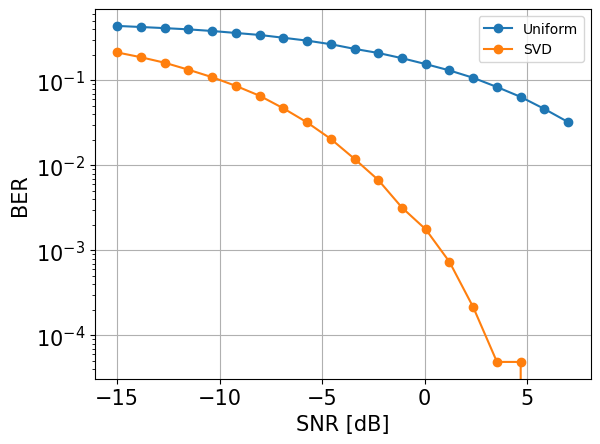

In [22]:
snr_range = np.linspace(-15, 7, 20)
uniform_ber_stat = get_ber_statistics(snr_range, "uniform", 1)
svd_ber_stat = get_ber_statistics(snr_range, "svd", 1)
plt.figure()

plt.plot(snr_range, uniform_ber_stat[0], 'o-', label = "Uniform")
plt.plot(snr_range, svd_ber_stat[0], 'o-', label = "SVD")

plt.yscale('log')
plt.grid()
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.legend(fontsize = 10)
plt.show()

**Задания:**
1. Реализовать пространственный согласованный фильтр (SVD-прекодер). Полученный график необходимо совместить с опорной кривой. По графику необходимо определить смещение кривой (рекомендуемые уровни BER $10^{-1}$ и $10^{-2}$)

2. Повторить задание 1. с двумя пространственными потоками данных; Проанализировать и дать обоснованный вывод относительно эффективности и целесообразности использования одного или двух потоков данных в данной реализации канала. Примечание: не забудьте разделить мощность передатчика между двумя потоками для корректного сравнения одно- и двухпоточной схем передачи.

In [23]:
def different_simulations(snr_range):
    uniform_ber_stat = get_ber_statistics(snr_range, "uniform", 1)
    svd_single_stat = get_ber_statistics(snr_range, "svd", 1)
    svd_double_stat = get_ber_statistics(snr_range, "svd", 2)
    ber_stats = np.concatenate((uniform_ber_stat, svd_single_stat, svd_double_stat), axis=0)
    names = ["Uniform single", "SVD single", "SVD double. Stream #1", "SVD double. Stream #2"]
    return (ber_stats, names)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

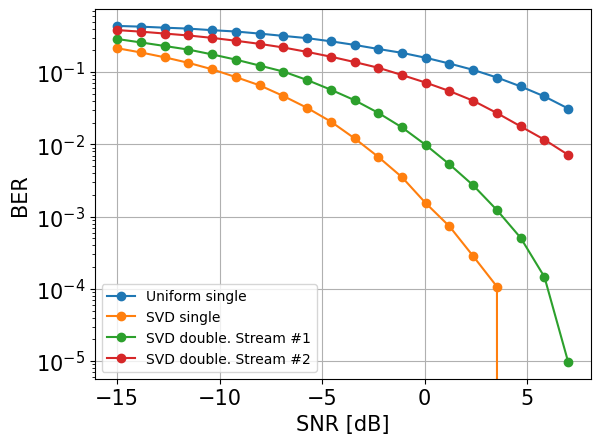

In [24]:
# Simulations.
# ---------------------------------------------------------------------------------------
# Your code here
snr_range = np.linspace(-15, 7, 20)
stats, names = different_simulations(snr_range)
# plot results
plt.figure()
for name, stat in zip(names, stats):
    plt.plot(snr_range, stat, 'o-', label = name)

plt.yscale('log')
plt.grid()
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.legend(fontsize = 10)
plt.show()

# ---------------------------------------------------------------------------------------

In [25]:
snr_range = np.linspace(-15, 7, 20)
svd_ber_stat, capacity_uniform = get_ber_statistics(snr_range, "uniform", 1, eval_capacity=True)
snr_range = np.linspace(-15, 7, 20)
svd_ber_stat, capacity_svd = get_ber_statistics(snr_range, "svd", 1, eval_capacity=True)
snr_range = np.linspace(-15, 7, 20)
svd_ber_stat, capacity_svd_2 = get_ber_statistics(snr_range, "svd", 2, eval_capacity=True)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

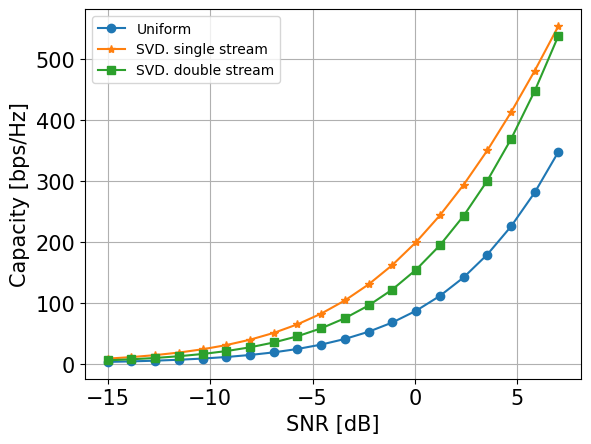

In [30]:
plt.figure()
plt.plot(snr_range, capacity_uniform, 'o-', label="Uniform")
plt.plot(snr_range, capacity_svd, '*-', label = "SVD. single stream")
plt.plot(snr_range, capacity_svd_2, 's-', label = "SVD. double stream")
plt.grid()
plt.xlabel('SNR [dB]')
plt.ylabel('Capacity [bps/Hz]')
plt.legend(fontsize = 10)
plt.show()

# Пространственные свойства сигнала
В этой части мы изучим пространственные свойства сигнала MIMO.
Прочитайте учебные материалы для этой части и реализуйте расчет пространственного спектра.

In [31]:
def get_spatial_spectre(H, use_shift_on_A = True, time_moment = 0, n_ue_val = None, n_sub_val = None):
    N_ue, N_bs, N_subcar, T = H.shape
    theta_amount = 200
    phi_amount = 200
    theta_range = np.linspace(-np.pi / 2, np.pi / 2, theta_amount)
    phi_range = np.linspace(-np.pi / 2, np.pi / 2, phi_amount)
    m = 4
    m_linspace = np.linspace(0, m - 1, m)
    n = 8
    n_linspace = np.linspace(0, n - 1, n)

    a_theta_plus = np.exp(-2j * np.pi * 0.9 * np.outer(m_linspace, np.sin(theta_range)))
    a_phi_plus = np.exp(-2j * np.pi * 0.5 * np.outer(n_linspace, np.sin(phi_range)))

    a_theta_minus = -1j * np.exp(-2j * np.pi * 0.9 * np.outer(m_linspace, np.sin(theta_range)))
    a_phi_minus = -1j * np.exp(-2j * np.pi * 0.5 * np.outer(n_linspace, np.sin(phi_range)))

    A_plus = np.zeros((m * n, theta_amount, phi_amount), dtype=np.complex128)
    A_minus = np.zeros((m * n, theta_amount, phi_amount), dtype=np.complex128)
    # print(phi_amount)
    for i in range(phi_amount):
        for j in range(theta_amount):
            res_plus = np.outer(a_phi_plus[:, i], a_theta_plus[:, j]).flatten()
            res_minus = np.outer(a_phi_minus[:, i], a_theta_minus[:, j]).flatten()
            # print(i, j, res)
            A_plus[:, j, i] = res_plus
            A_minus[:, j, i] = res_minus

    # H_plus = H[0, 0:32, ...]
    # H_minus = H[0, 32:, ...]
    if n_ue_val != None:
        n_ue_range = range(n_ue_val, n_ue_val + 1)
        n_ue_divide_factor = 1
    else:
        n_ue_range = range(N_ue)
        n_ue_divide_factor = N_ue

    if n_sub_val != None:
        n_sub_range = range(n_sub_val, n_sub_val + 1)
        n_sub_divide_factor = 1
    else:
        n_sub_range = range(N_subcar)
        n_sub_divide_factor = N_subcar

    ro = np.zeros((theta_amount, phi_amount))
    for n_ue in tqdm(n_ue_range):
        for carrier in n_sub_range:
            H_plus = np.expand_dims(H[n_ue, 0:32, carrier, time_moment], 0)
            H_minus = np.expand_dims(H[n_ue, 32:, carrier, time_moment], 0)
            # print(H_plus.shape)
            # print(H_minus.shape)
            # print(A.shape)

            res1 = np.einsum("AB,BCD->ACD", np.conj(H_plus), A_plus)
            if use_shift_on_A:
                res2 = np.einsum("AB,BCD->ACD", np.conj(H_minus), A_minus)
            else:
                res2 = np.einsum("AB,BCD->ACD", np.conj(H_minus), A_plus)

            power = np.squeeze(np.square(np.abs(res1 + res2)), 0)
            ro += power
            # print(ro)
            # ro += np.squeeze(np.square(np.abs(res1 + res2)), 0)
    ro = ro / n_ue_divide_factor
    ro = ro / n_sub_divide_factor
    ro = np.log(ro)
    # print(ro)
    plt.pcolor(90 * theta_range  * 2 / np.pi, 90 * phi_range * 2 / np.pi, ro, label="Power")
    plt.xlabel("Azimuth [deg]")
    plt.ylabel("Elevation [deg]")
    title_str = f'Mean spatial spectrum, t = {time_moment}'
    if not (n_ue_val is None):
        title_str += f', n_ue = {n_ue_val}'
    if not (n_sub_val is None):
        title_str += f', n_sub = {n_sub_val}'
    # if (n_sub_val is None) and (n_ue_val is None):
    #     if use_shift_on_A: 
    #         title_str += ', A^{+} and A^{-} were used'
    #     else:
    #         title_str += ', only A^{+} was used'
    plt.title(title_str)
    c = plt.colorbar()
    c.set_label("Power [dB]")
    plt.show()
    # A = np.einsum("NS,MF->NMSF", a_phi_plus, a_theta_plus)
    # print(A.shape)
    # A = np.reshape(A, (m_small * n_small, phi_amount, theta_amount))
    # print(A.shape)
    # print(a_phi_plus[:, 0])
    # print(a_theta_plus[:, 1])
    # print(A[:, 1, 0])
    # a_theta_minus = -1j * a_theta_plus
    # a_phi = -1j * a_phi_plus

  0%|          | 0/1 [00:00<?, ?it/s]

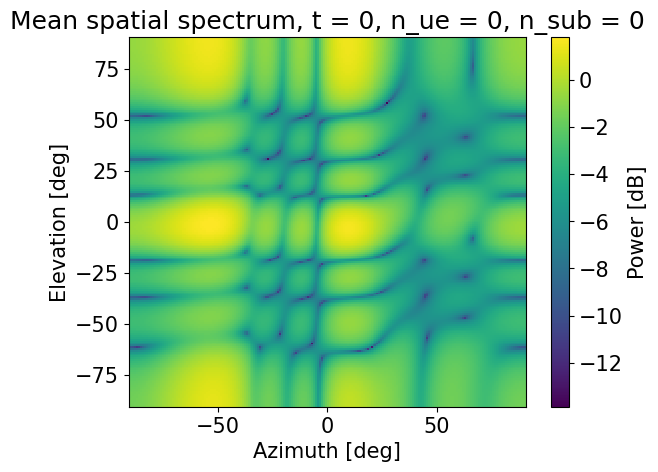

  0%|          | 0/1 [00:00<?, ?it/s]

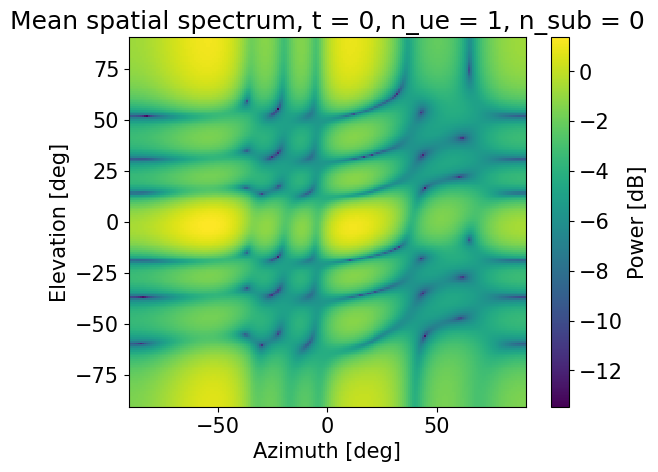

  0%|          | 0/1 [00:00<?, ?it/s]

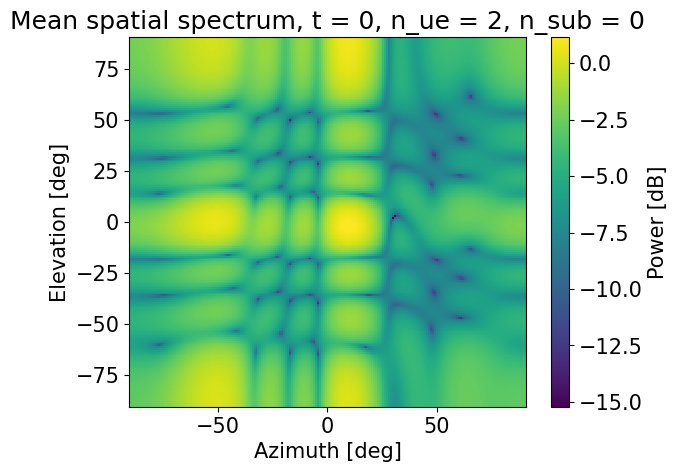

  0%|          | 0/1 [00:00<?, ?it/s]

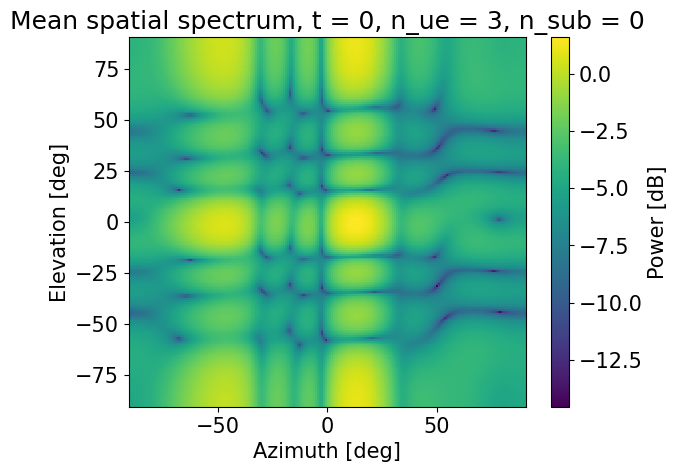

  0%|          | 0/1 [00:00<?, ?it/s]

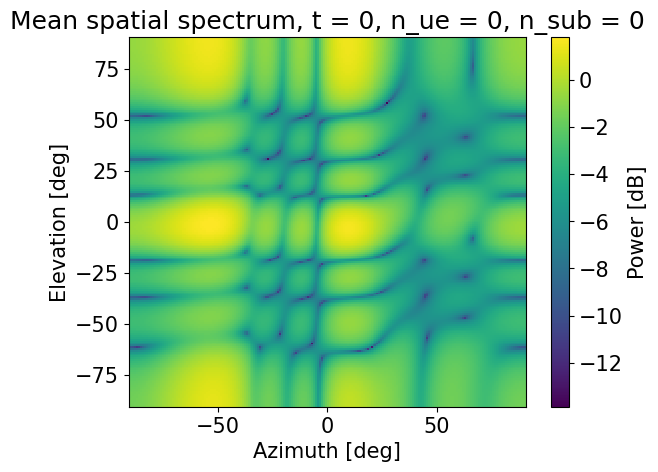

  0%|          | 0/1 [00:00<?, ?it/s]

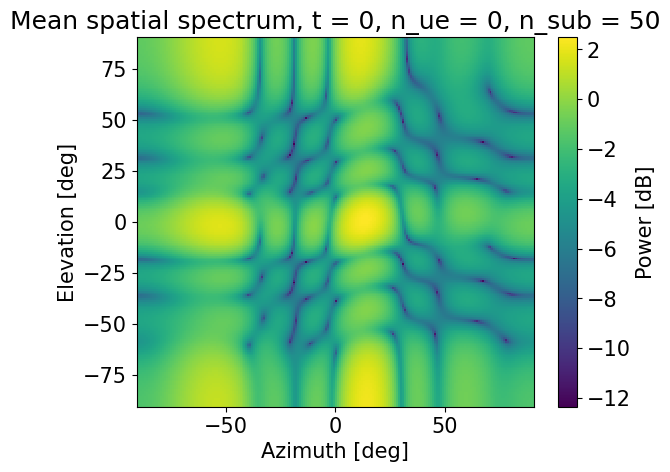

  0%|          | 0/1 [00:00<?, ?it/s]

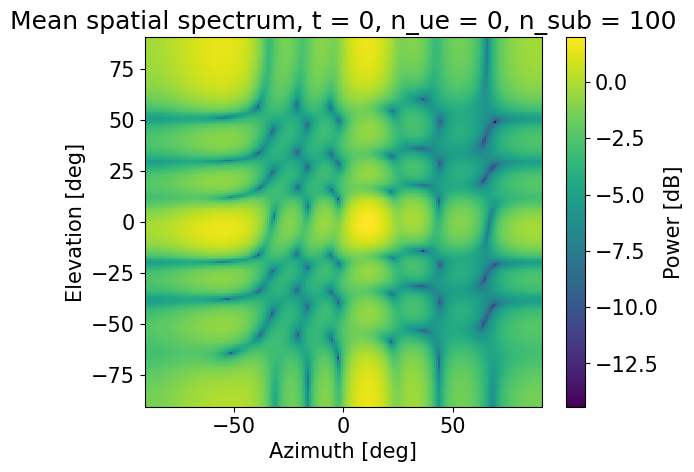

  0%|          | 0/1 [00:00<?, ?it/s]

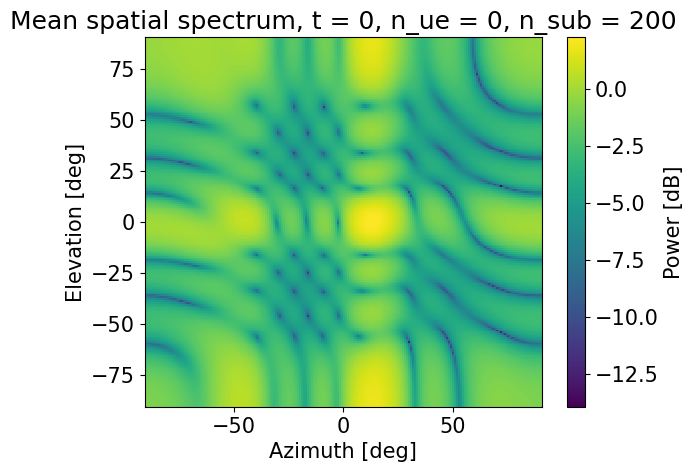

In [32]:
get_spatial_spectre(H, False, time_moment=0, n_ue_val = 0, n_sub_val=0)
get_spatial_spectre(H, False, time_moment=0, n_ue_val = 1, n_sub_val=0)
get_spatial_spectre(H, False, time_moment=0, n_ue_val = 2, n_sub_val=0)
get_spatial_spectre(H, False, time_moment=0, n_ue_val = 3, n_sub_val=0)
get_spatial_spectre(H, False, time_moment=0, n_ue_val = 0, n_sub_val=0)
get_spatial_spectre(H, False, time_moment=0, n_ue_val = 0, n_sub_val=50)
get_spatial_spectre(H, False, time_moment=0, n_ue_val = 0, n_sub_val=100)
get_spatial_spectre(H, False, time_moment=0, n_ue_val = 0, n_sub_val=200)

  0%|          | 0/4 [00:00<?, ?it/s]

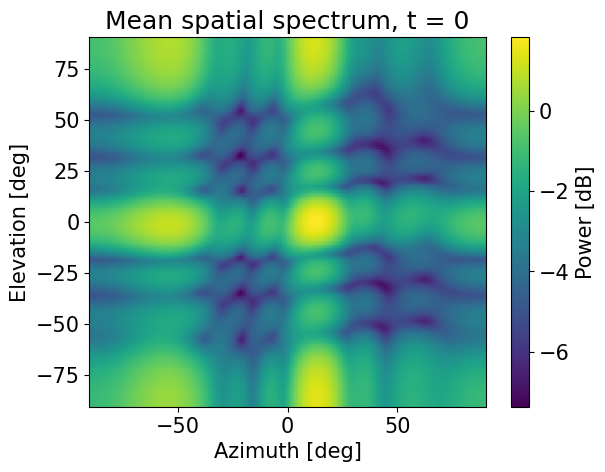

  0%|          | 0/4 [00:00<?, ?it/s]

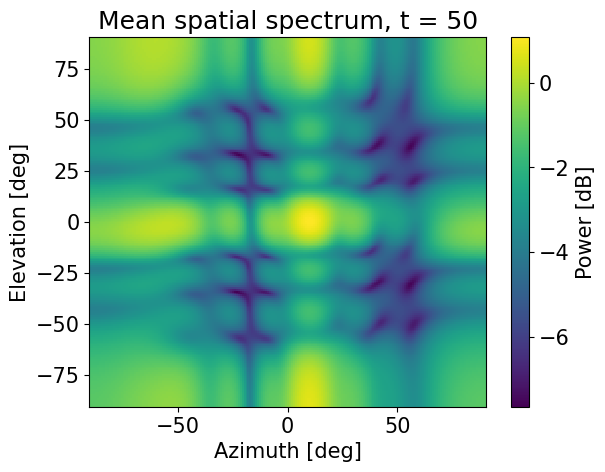

  0%|          | 0/4 [00:00<?, ?it/s]

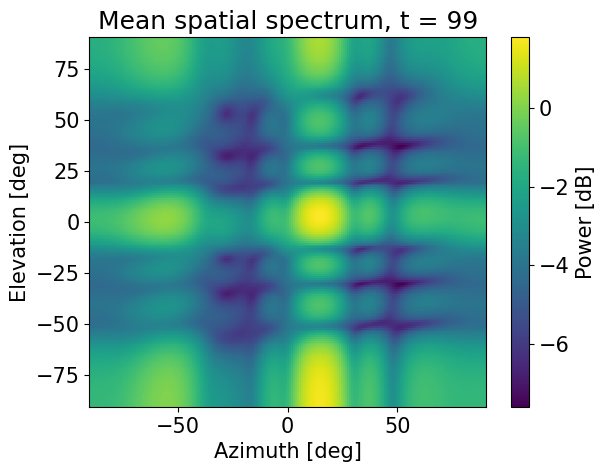

In [33]:
get_spatial_spectre(H, False, time_moment=0)
get_spatial_spectre(H, False, time_moment=50)
get_spatial_spectre(H, False, time_moment=99)


  0%|          | 0/4 [00:00<?, ?it/s]

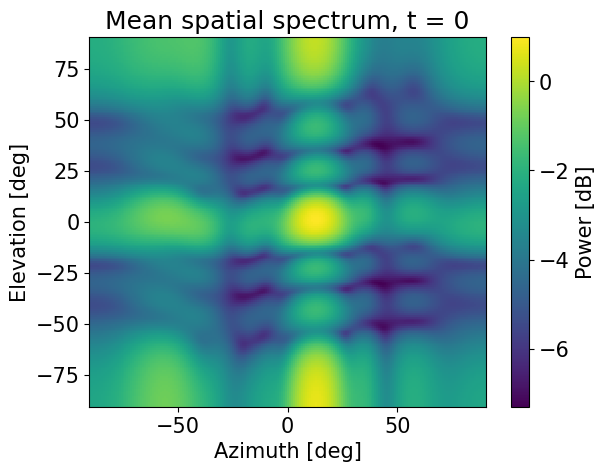

  0%|          | 0/4 [00:00<?, ?it/s]

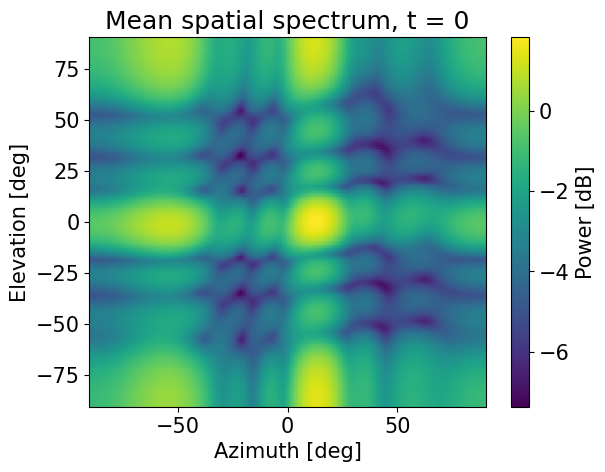

In [34]:
get_spatial_spectre(H, True)
get_spatial_spectre(H, False)

В этом задании вам необходимо реализовать лучевую аппроксимацию канала (beam approximation), описанного в методических материалах.

In [35]:
def beam_approximate(H_input, N_beams):
    to_squeeze_back = False
    if len(H_input.shape) == 3:
        H_input = np.expand_dims(H_input, 3)
        to_squeeze_back = True

    N_ue_ants, N_bs_ants, N_subcarriers, N_times = H_input.shape
    assert N_bs_ants >= N_beams
    H_approximate = np.zeros(H_input.shape, dtype=np.complex128)

    # ---------------------------------------------------------------------------------------
    # Your code here

    k_values = np.arange(0, N_bs_ants)
    index_mat = np.outer(k_values, k_values / N_bs_ants)
    # print(index_mat)
    Fourier_mat = np.exp(-1j * 2 * np.pi * index_mat)
    inv_Fourier_mat = np.linalg.inv(Fourier_mat)
    
    # # # Fourier_transformed = np.einsum("ABCD,BB->ABCD", H, Fourier_mat)
    # rolled = np.expand_dims(np.swapaxes(H, 1, -1), 3)
    # Fourier_transformed =np.matmul(rolled, Fourier_mat)# np.einsum("ABCD,BB->ABCD", H, Fourier_mat)
    # Fourier_transformed = np.squeeze(Fourier_transformed, 3)
    # Fourier_transformed = np.transpose(Fourier_transformed, (0, 3, 2, 1))

    # # # print(Fourier_transformed.shape)
    # argmaxes = (np.argpartition(np.abs(Fourier_transformed), -N_beams, axis=1)[:, -N_beams:, ...])
    # choose_arr = np.full(Fourier_transformed.shape, True)
    
    # for n_ue in range(N_ue_ants):
    #     for n_sub in range(N_subcarriers):
    #         for n_t in range(N_times):
    #             indices = argmaxes[n_ue, :, n_sub, n_t]
    #             choose_arr[n_ue, indices, n_sub, n_t] = False
    # Fourier_transformed[choose_arr] = 0
    # # H_approximate = np.einsum("ABCD,BB->ABCD", Fourier_transformed, inv_Fourier_mat)
    # rolled_Fourier = np.expand_dims(np.swapaxes(Fourier_transformed, 1, -1), 3)
    # H_approximate = np.matmul(rolled_Fourier, inv_Fourier_mat)
    # H_approximate = np.squeeze(H_approximate, 3)
    # H_approximate = np.transpose(H_approximate, (0, 3, 2, 1))

    Fourier_transformed = np.fft.fft(H_input, axis=1)
    argmaxes = (np.argpartition(np.abs(Fourier_transformed), kth=-N_beams, axis=1)[:, -N_beams:, ...])
    choose_arr = np.full(Fourier_transformed.shape, True)
    
    for n_ue in range(N_ue_ants):
        for n_sub in range(N_subcarriers):
            for n_t in range(N_times):
                indices = argmaxes[n_ue, :, n_sub, n_t]
                choose_arr[n_ue, indices, n_sub, n_t] = False
    Fourier_transformed[choose_arr] = 0
    H_approximate = np.fft.ifft(Fourier_transformed, axis=1)
    

    # for n_ue in range(N_ue_ants):
    #     for n_sub in range(N_subcarriers):
    #         for time_moment in range(N_times):
    #             h = H_input[n_ue, :, n_sub, time_moment]
    #             h = np.expand_dims(h, 0)

    #             # h_Fourier = np.matmul(h, Fourier_mat)
    #             h_Fourier = np.fft.fft(h)
    #             # if not np.allclose(check, h_Fourier):
    #             #     raise ValueError("Err on 1")
    #             argmaxes = (np.argpartition(np.abs(h_Fourier[0]), -N_beams)[-N_beams:])
    #             
    #             choose_arr = np.full(h.shape, True)
    #             choose_arr[0, argmaxes] = False
    #             # choose_arr[0, argmaxes] = False
    #             h_Fourier[choose_arr] = 0
    #             # h_recovered = np.matmul(h_Fourier, inv_Fourier_mat)
    #             h_recovered = np.fft.ifft(h_Fourier)
    #             # if not np.allclose(check2, h_recovered):
    #             #     raise ValueError("Err on 2")
    #             H_approximate[n_ue, :, n_sub, time_moment] = h_recovered[0]

    H_approximate = normalize(H_approximate)
    if to_squeeze_back == True:
        H_approximate = np.squeeze(H_approximate, 3)
    # ---------------------------------------------------------------------------------------

    return H_approximate

In [36]:
full_approx = beam_approximate(H, 64)
# print(full_approx.shape)
# print(H.shape)
# print(abs(full_approx - H))
# print(abs(H))
# print(abs(full_approx))


In [37]:
print(np.allclose(H, full_approx))
approximated = beam_approximate(H, 1)

True


  0%|          | 0/4 [00:00<?, ?it/s]

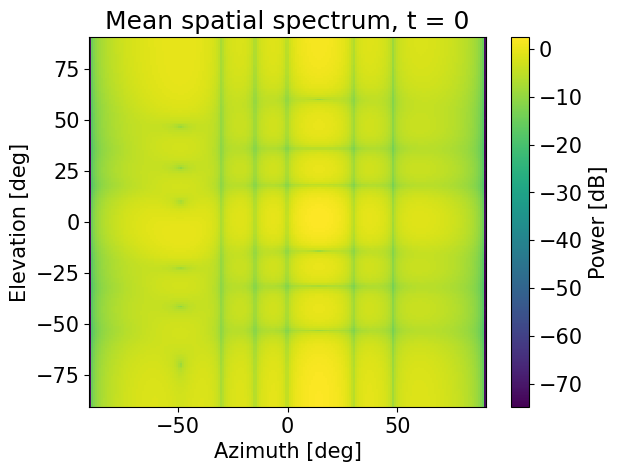

In [38]:
get_spatial_spectre(approximated, 0)

In [39]:
def plot_with_beams():
    snr_range = np.linspace(-15, 7, 20)
    stats, names = different_simulations(snr_range)

    # SVD simulations. 8 beam approx
    # ---------------------------------------------------------------------------------------
    # Your code here
    # approx_64_func = functools.partial(beam_approximate, N_beams=64)
    # svd_64_beam = get_ber_statistics(snr_range, "svd", 1, approx_64_func)

    approx_8_func = functools.partial(beam_approximate, N_beams=8)
    svd_8_beam = get_ber_statistics(snr_range, "svd", 1, approx_8_func)
    # ---------------------------------------------------------------------------------------

    # SVD simulations. 1 beam approx
    # ---------------------------------------------------------------------------------------
    approx_1_func = functools.partial(beam_approximate, N_beams=1)
    svd_1_beam = get_ber_statistics(snr_range, "svd", 1, approx_1_func)
    # Your code here
    # ---------------------------------------------------------------------------------------
    # plot results
    plt.figure()
    for name, stat in zip(names, stats):
        plt.plot(snr_range, stat, 'o-', label = name)
    # plt.plot(snr_range, svd_64_beam[0], 'o-', label = "SVD. 64 beam")
    plt.plot(snr_range, svd_8_beam[0], 'o-', label = "SVD. 8 beam")
    plt.plot(snr_range, svd_1_beam[0], 'o-', label = "SVD. 1 beam")

    plt.yscale('log')
    plt.grid()
    plt.xlabel('SNR [dB]')
    plt.ylabel('BER')
    plt.legend(fontsize = 10)
    plt.show()


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

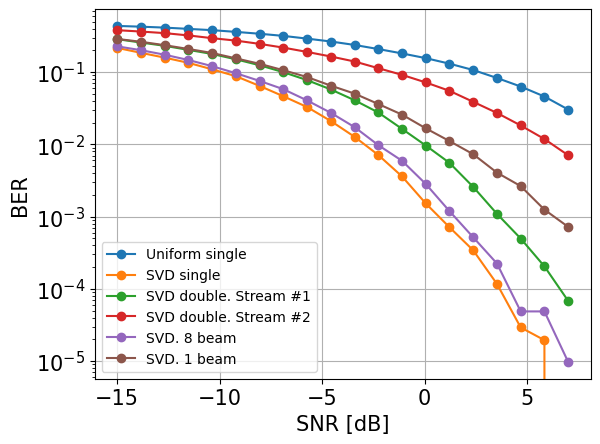

In [40]:
plot_with_beams()

Построить пространственные спектры сигналов для аппроксимированных каналов

  0%|          | 0/4 [00:00<?, ?it/s]

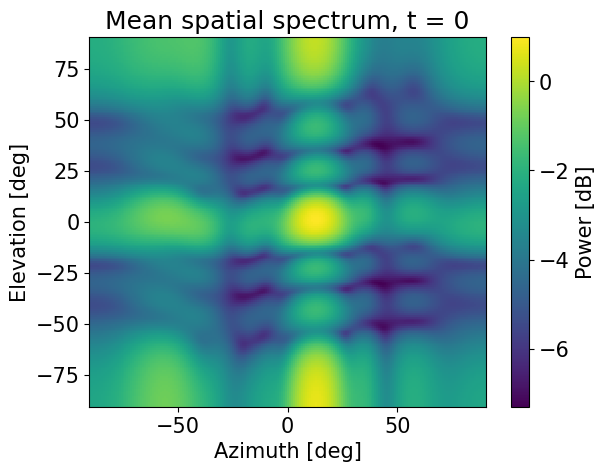

  0%|          | 0/4 [00:00<?, ?it/s]

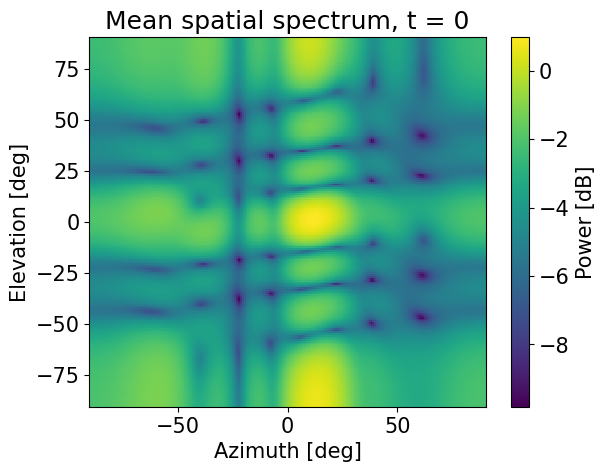

  0%|          | 0/4 [00:00<?, ?it/s]

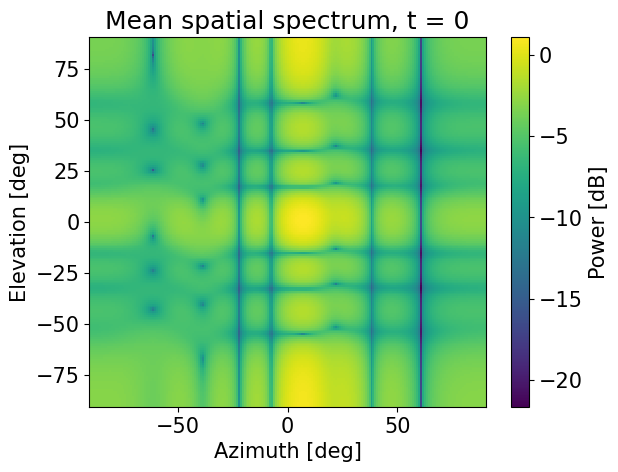

In [41]:
# ---------------------------------------------------------------------------------------
# Your code here
approximated_with_64 = beam_approximate(H, 64)
get_spatial_spectre(approximated_with_64)
approximated_with_8 = beam_approximate(H, 8)
get_spatial_spectre(approximated_with_8)
approximated_with_1 = beam_approximate(H, 1)
get_spatial_spectre(approximated_with_1)
# ---------------------------------------------------------------------------------------

# Исследование влияния ошибок CSI на алгоритмы пространственного прекодирования

В предыдущей задаче мы использовали идеальное знание канала на стороне приемника, когда применяли эквалайзер. Однако в реальном случае нам нужно как-то измерить этот канал. Обычно это делается путем отправки сигнала, который известен пользовательскому оборудованию и базовой станции. Такой сигнал называется пилот-сигналом. В этой задаче мы попытаемся оценить канал с помощью опорных зондирующих сигналов (SRS), которые были представлены на лекциях. Такие сигналы SRS будут передаваться стороной UE и приниматься на базовой станции. После этого базовая станция оценит канал и использует его для построения прекодера, а затем отправит некоторые данные обратно на сторону UE. Таким образом, в этой части у нас есть передача по восходящей линии (UL) связи (пилот-сигналы SRS) и передача по нисходящей линии (DL) связи (данные). Предполагая, что у нас есть система FDD, передача по восходящей и нисходящей линии связи должна применяться на разных поднесущих. Однако в таком случае нам необходимо интерполировать оценку канала по восходящей линии связи, чтобы получить оценку канала по нисходящей линии связи. Этот случай будет рассмотрен в последнем домашнем задании, сейчас для простоты мы будем использовать одни и те же частотные ресурсы для UL и DL.

Что касается оценки канала, на него влияет не только шум, но и помехи от другого пользователя. В этой задаче для простоты мы будем использовать только один элемент антенны на UE для всех описанных процедур. И мы будем использовать другой канал в качестве мешающего сигнала.

Сигналы SRS были настроены с помощью встроенной функции Matlab (вы можете проверить версию кода Matlab) и сохранены в файле mat. Теперь мы можем просто загрузить этот файл. Он имеет два поля:

1. `SRS_SC` - поднесущие, которые используются для отправки SRS
2. `SRS_SEQ` - 8 сигналов SRS, которые являются смещенными последовательностями Задова-Чу

Таким образом, нам нужно выбрать только поднесущие `SRS_SC` из исходного канала

In [42]:
# import some functions that will be used frequenly
from numpy.fft import fft, ifft, fftshift, ifftshift
import scipy

In [43]:
# subcarrier indices, where SRS pilots are placed
srs_subcarriers = scipy.io.loadmat('/home/lexotr/my_gits/9_semester_programming/mimo/first_hw/srs_sig.mat')['SRS_SC'].flatten()

# SRS signals. Zadoff-Chu sequencies
srs_signal = scipy.io.loadmat('/home/lexotr/my_gits/9_semester_programming/mimo/first_hw/srs_sig.mat')['SRS_SEQ']

print('SRS subc: ', srs_subcarriers.shape)
print('SRS signals: ', srs_signal.shape)

SRS subc:  (288,)
SRS signals:  (8, 288)


Также мы используем свойство взаимности канала, которое означает, что каналы UL и DL идентичны с точностью до сопряженного транспонирования.
Итак, если у нас есть $H_{DL} \in \mathbb{C}^{M \times N}$, и $H_{UL} \in \mathbb{C}^{N \times M}$, то:
$$
H_{DL} = H^H_{UL}
$$

In [44]:
# Upload target channel
CHAN_NAME = 'link_chan_{}.mat'.format('2')
H_DL = normalize(scipy.io.loadmat(CHAN_NAME)['Link_Channel'])
H_UL = H_DL.conj().swapaxes(0,1)

# select subcarriers where we have pilots
H_DL = H_DL[:,:,srs_subcarriers,:]
H_UL = H_UL[:,:,srs_subcarriers,:]

target_ue = [1]  # used UE antenna
target_srs = [4] # used SRS signal

interf_ue = [1]  # used UE antenna
interf_srs = [3] # used SRS signal

In [45]:
# Upload interfered channel
CHAN_NAME = 'link_chan_{}.mat'.format('3')
H_DL_interf = normalize(scipy.io.loadmat(CHAN_NAME)['Link_Channel'])
H_UL_interf = H_DL_interf.conj().swapaxes(0,1)

# select subcarriers
H_UL_interf = H_UL_interf[:,:,srs_subcarriers,:]

Давайте наглядно продемонстрируем, что мы собираемся сделать в этой части задания, используя только первый момент времени:

In [46]:
# fix some time moment
t = 0
H_DL_t = H_DL[..., t]
H_UL_t = H_UL[..., t]

H_UL_t_interf = H_UL_interf[...,0]

print('H_DL_t: ', H_DL_t.shape)
print('H_UL_t: ', H_UL_t.shape)
print('H_UL_t_interf: ', H_UL_t_interf.shape)

H_DL_t:  (4, 64, 288)
H_UL_t:  (64, 4, 288)
H_UL_t_interf:  (64, 4, 288)


Теперь мы хотели бы смоделировать передачу SRS от целевого UE к базовой станции, поэтому мы будем использовать канал Uplink. Поскольку у нас есть только одна передающая антенна, мы можем записать это следующим образом:
$$
\mathop{\mathrm{y_p(k,t)}}_{N \times 1} = \mathop{\mathrm{h_{UL}(k,t) }}_{N\times 1} \mathop{\mathrm{s_p(k,t)}}_{1 \times 1}
$$
где $y_p$ — это принятый пилот-сигнал на базовой станции, $h_{UL}$ — это канал Uplink, а $s_p$ — это сигнал SRS.
Вы можете упростить это уравнение и его реализацию, но исходная функция `receiver_signal` также хорошо работает:

In [47]:
# received signal at BS from target user without noise
y_target = receiver_signal(H_UL_t[:,target_ue], srs_signal[target_srs], SNR_dB = None)

# received signal at BS from interfered user without noise
y_interf = receiver_signal(H_UL_t_interf[:,interf_ue], srs_signal[interf_srs], SNR_dB = None)

print('y: ',y_target.shape)

y:  (64, 288)


Теперь вы можете исследовать кросс-корреляционные свойства исходного сигнала SRS и полученной версии. Для этого переведем сигнал из частотной области (поднесущие) во временную область (задержки).

In [48]:
def correlate_time_domain(x1, x2, normalize = True):
    '''
    Calculates crosscorreltion between two signals in the time domain.
    INPUTS:
        - x1: (np.ndarray) first signal array
        - x2: (np.ndarray) second signal array
        - normalize: (bool). If 'True' then normalize result to have max amplitude equal to 1.
          if 'False' then normalization is not applied
    OUTPUTS:
        - Absolute value of crosscorrelataion between X1 and X2, where X1 and X2
          are inverse Fourier transfrom of x1 and x2 respectively.
    '''

    # Your code here
    # ---------------------------------------------------------------------------------------
    #   IFFT of x1
    x1_ifft = ifft(x1)

    #   IFFT of x2
    x2_ifft = ifft(x2)

    #   crosscorrelation of previous signals
    corr = scipy.signal.correlate(x1_ifft, x2_ifft)
    # print(f"shapes: {x1_ifft.shape}, {x2_ifft.shape}, {corr.shape}")

    #   absolute value of crosscorrelation
    #   abs_corr =
    abs_corr = np.abs(corr)

    # ---------------------------------------------------------------------------------------


    if normalize:
        abs_corr /= np.max(abs_corr)

    return abs_corr


def get_dft_axis(x):
    '''
    Reorders axis according to DFT, having 0 DFT bin in the middle of input vector
    '''
    assert len(x.shape) == 1 , 'Only vectors are allowed'
    N = len(x)  # number of elements in the input vector

    # if Number of elements is even
    if N % 2 == 0:
        x_axis =  np.arange(start = - N//2, stop = N//2 , step = 1)
    # if Number of elements is odd
    else:
        x_axis = np.arange(start = -(N-1)//2, stop = (N-1)//2 + 1, step = 1)
    return x_axis

Давайте рассмотрим взаимную корреляцию между различными сигналами SRS. Как вы можете объяснить полученный результат?

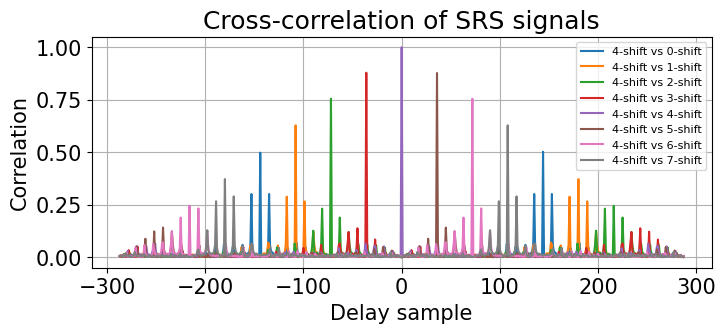

In [49]:
plt.figure(figsize = (8,3))
for i in range(srs_signal.shape[0]):
    c = correlate_time_domain(srs_signal[4], srs_signal[i], normalize = False)
    # print(c)
    plt.plot(get_dft_axis(c), c, label = '4-shift vs {0}-shift'.format(i) )
plt.ylabel('Correlation')
plt.xlabel('Delay sample')
plt.title('Cross-correlation of SRS signals')
plt.grid()
plt.legend(fontsize = 8)
plt.show()

Давайте рассмотрим свойства взаимной корреляции исходного сигнала SRS и его принятой версии после прохождения канала.

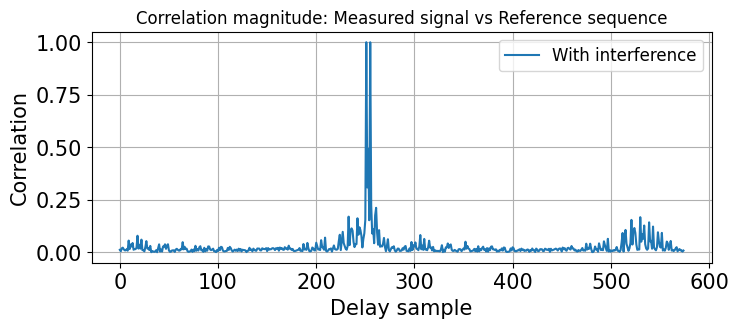

In [50]:
# autocorrelation of SRS for target UE
# print(srs_signal[target_srs].shape)
# print(y_target[0].shape)
# print(y_interf[0].shape)
corr_without_channel = correlate_time_domain(srs_signal[target_srs][0],
                                             srs_signal[target_srs][0],
                                             normalize = True)

# cross-correlation for target SRS and received target SRS
corr_with_channel = correlate_time_domain(srs_signal[target_srs][0],
                                          y_target[0], # fixing some BS ant
                                          normalize = True)

# cross-correlation for target SRS and received interfered SRS
corr_interfrence = correlate_time_domain(srs_signal[target_srs][0],
                                         y_interf[0], # fixing some BS ant
                                         normalize = True)

# Plot correlations
plt.figure(figsize = (8,3))
# plt.plot(corr_with_channel, label = 'With channel')
# plt.plot(corr_without_channel, label = 'Without channel')
plt.plot(corr_interfrence, label = 'With interference')
plt.grid()
plt.title('Correlation magnitude: Measured signal vs Reference sequence', fontsize = 12)
plt.legend(fontsize = 12)
plt.ylabel('Correlation')
plt.xlabel('Delay sample')
plt.show()

Из цифровой обработки сигналов вы, возможно, помните, что канал можно описать его импульсной характеристикой, которая может быть получена с помощью обратного преобразования Фурье канала. Постройте амплитудный спектр импульной характеристики. Какой можно сделать из неё вывод о свойствах канала?

[0.02083604 0.00744993 0.00945024 0.00156885 0.0110874  0.00636435
 0.00692233 0.00641981 0.02080301 0.00818318]


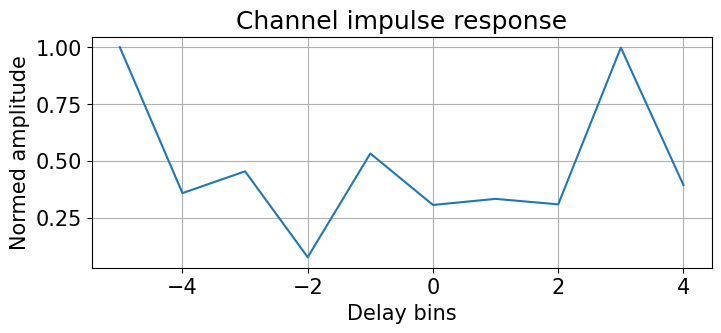

In [51]:
# CIR plotting for fixed pair of antennas
def plot_CIR(x):
    assert len(x.shape) == 1, 'Only vectors are allowed'

    plt.figure(figsize = (8,3))
    cir = fftshift(np.abs(ifft(x)))
    start = int(cir.size / 2)
    len_to_look = 10
    cir_min = np.argmin(cir[start: start + len_to_look])
    print(cir[start: start + len_to_look])
    cir_normalized = cir/np.max(cir)
    plt.plot(get_dft_axis(cir_normalized[start: start + len_to_look]), cir_normalized[start: start + len_to_look])
    plt.grid()
    plt.title('Channel impulse response')
    plt.ylabel('Normed amplitude')
    plt.xlabel('Delay bins')
    plt.show()

plot_CIR(H_DL_t[target_ue[0], 0])

Теперь мы получили пилот-сигнал $y_p$ на базовой станции. Также BS знает точный сигнал $s_p$, который был передан. Теперь мы можем оценить канал следующим образом:
$$
\mathop{\mathrm{\hat{h}_{UL}(k,t)}}_{N \times 1} = \mathop{\mathrm{y_p(k,t)}}_{N\times 1} \mathop{\mathrm{s_p^*(k,t)}}_{1 \times 1}
$$

In [52]:
def LS_channel_est(y,s):
    '''
    LS channel estimation.
    INPUTS:
        - y: (np.ndarray) received pilot signal with shape of [N_bs_ants x N_subcarriers]
        - x: (np.ndarray) transmitted pilot signal with shape of [N_subcarriers]
    '''

    N_bs, N_subc = y.shape
    h_est = np.zeros((N_bs, 1, N_subc), dtype = np.complex128)

    # ---------------------------------------------------------------------------------------
    # Your code here
    y_expanded = np.expand_dims(y, 1)
    s_expanded= np.expand_dims(s, 0)
    h_est = np.einsum("MAK,AK->MAK", y_expanded, np.conj(s_expanded))
    # print(h_est.shape)
    # print(y.shape)
    # print(s.shape)
    # ---------------------------------------------------------------------------------------

    return h_est

Теперь мы можем легко получить расчетный канал для нисходящей линии связи, используя свойство взаимности:

In [53]:
H_est_UL = LS_channel_est(y_target, srs_signal[0])
H_est_DL = H_est_UL.swapaxes(0,1).conj()
print(H_est_DL.shape)

(1, 64, 288)


Наконец, мы можем использовать предполагаемый канал DL для расчета прекодера на передатчике, чтобы отправить некоторые данные с базовой станции пользователю.
Однако ранее мы получили пилот-сигнал $y_p$ без шума и помех, но они оказали значительное влияние на конечный результат. В этом домашнем задании вам нужно будет провести моделирование, когда:

1. У нас есть идеальная оценка канала $y_p$
2. Оценка канала, полученная с шумом: $y_p + n$
3. Оценка канала, полученная с помехами $y_p^{(UE_1)} + y_p^{(UE_2)}$
4. с оценкой канала, полученной с шумом и помехами $y_p^{(UE_1)} + y_p^{(UE_2)} + n$

Давайте покажем моделирование с идеальной оценкой канала.

In [54]:
# Modulation scheme
N_constellation_points = 16
N_bits_per_conts_point = int(np.log2(N_constellation_points))
modem = QAMModem(M = N_constellation_points,
                 bin_input = True,
                 gray_map = True,
                 soft_decision = False,
                 bin_output = True)
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

# Generate bit sequence that will be transmitted to UE
input_bits = np.random.binomial(n = 1, p = 0.5,
                                size = (1, 288, N_bits_per_conts_point))

# Modulated signal
ofdm_symbols = modem.modulate(input_bits.flatten()).reshape(1, 288) / constellation_norm

Теперь мы используем предполагаемый канал Downlink для расчета прекодера SVD. Поскольку у нас есть только 1 антенна на стороне приёмника, мы можем использовать только 1 слой для передачи. Более того, наш канал является вектором для текущей ситуации, что означает, что нет необходимости использовать функцию `scipy.linalg.svd` для получения требуемого прекодера. Запишите точную формулу для прекодера SVD в таком случае. Вы можете изменить функцию прекодирования для такого случая (MISO) или использовать уже реализованную функцию как есть, потеряв возможность уменьшить сложность:

In [55]:
# calulate precoder
precoder = get_precoder(H_est_DL, 1 ,'svd')
precoder.shape

(64, 1, 288)

In [56]:
# Calculate transmitted signal
X = transmitter_signal(s_signal = ofdm_symbols, precoder = precoder)
X.shape

(64, 288)

In [57]:
# Signal at the receiver side
# We use here physically real DL channel for target user!
Y = receiver_signal(H_DL_t[target_ue], X, None)
Y.shape

(1, 288)

В эквалайзере для простоты мы предполагаем идеальную оценку канала, поскольку наша цель — исследовать влияние оценки канала на построение прекодера для передачи по нисходящей линии связи. Во всех ваших симуляциях вы используете идеальную оценку канала DL!

In [58]:
# Ideal channel estimation
H_eff = effective_channel(H_DL_t[target_ue], precoder)

# Equalizer
S_est = equalize(Y, H_eff) * constellation_norm

# estimated bit sequence
bits_est = modem.demodulate(S_est.flatten()).reshape(1, -1)

# obtaining BER
bit_error_rate(bits_est, input_bits.reshape(1, -1))

array([0.])

Теперь соберите все вместе и выполните моделирование для предварительного кодера SVD с идеальной и неидеальной оценкой канала, чтобы получить кривые BER:

In [59]:
def send_experiment_with_channel_approx(snr_range, precoder_type, window, noise_uplink_flag, interfere_flag):
    N_ue, N_bs_ants, N_subcarriers, N_tti = H_DL.shape
    N_layers = 1
    N_constellation_points = 16
    N_bits_per_conts_point = int(np.log2(N_constellation_points))
    modem = QAMModem(M = N_constellation_points,
                    bin_input = True,
                    gray_map = True,
                    soft_decision = False,
                    bin_output = True)
    constellation_norm = (2/3 * (N_constellation_points - 1))**0.5
    bers = np.zeros((N_layers, len(snr_range)))

    for snr_idx, snr in enumerate(tqdm(snr_range)):
        ber_per_time = np.zeros((N_layers, N_tti))
        for t in range(N_tti):

            # Uplink. SRS
            # ---------------------------------------------------------------------------------------
            # Your code here

            #   slice current tti for target and interfering channels
            signal_target = srs_signal[target_srs]
            signal_interf = srs_signal[interf_srs]

            #   calculate received signals for target and interference
            # received signal at BS from target user without noise
            #   !!! Add noise ONLY to target received signal !!!
            H_DL_t = H_DL[..., t]
            H_UL_t = H_UL[..., t]
            H_UL_t_interf = H_UL_interf[...,t]
            H_DL_t_interf = H_DL_interf[...,t]

            if noise_uplink_flag:
                snr_uplink = snr
            else:
                snr_uplink = None
            y_target = receiver_signal(H_UL_t[:,target_ue], signal_target, SNR_dB = snr_uplink)

            # received signal at BS from interfered user without noise
            if interfere_flag:
                y_interf = receiver_signal(H_UL_t_interf[:,interf_ue], signal_interf, SNR_dB = None)
            else:
                y_interf = np.zeros(y_target.shape, dtype=np.complex128)

            # sum receved signals for target and interference (if required)
            y_sum = y_target + y_interf


            #   Obtain UL and then DL channel estimation

            #   Apply filter (if required) for DL estimated channel
            H_est_UL = LS_channel_est(y_sum, srs_signal[0])
            H_est_DL = H_est_UL.swapaxes(0,1).conj()
            if not (window is None):
                H_est_DL = window_filter(H_est_DL, window)


            # Downlink. Data transmission.
            # ---------------------------------------------------------------------------------------
            #   ...Same actions as in 1-st part of the homework...
            #   !!! Estimated DL channel used only for precoder calculation !!!
            #   !!! Use ideal channel estimation for DL equalizer !!!
            # ---------------------------------------------------------------------------------------

            bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers, N_subcarriers, N_bits_per_conts_point))
            # print(f"bits shape {bits.shape}")

            # Create 1 OFDM symbol with N_subcarriers QAM symbols.
            qam_symbols = modem.modulate(bits.flatten()).reshape((N_layers, N_subcarriers)) / constellation_norm
            # print(f"qam symb shape {qam_symbols.shape}")
            precoder = get_precoder(H = H_est_DL, rank = N_layers, precoder_type = precoder_type)
            # print(precoder.shape)
            X = transmitter_signal(s_signal = qam_symbols, precoder = precoder)
            # print(f"X shape {X.shape}")

            # Obtain signal with noise
            Y_noisy = receiver_signal(H_DL_t[target_ue], X, snr)
           
            # Y_ideal = receiver_signal(Ht, X, None)
            # Noise = Y_noisy - Y_ideal
            # Signal_power_dB = 10 * np.log10( np.mean( np.abs(Y_ideal)**2 ))
            # Noise_power_dB = 10 * np.log10( np.mean( np.abs(Noise)**2 ))
            # print('SNR: ', Signal_power_dB - Noise_power_dB, 'dB, and should be', snr)

            # print(f"Y shape {Y_noisy.shape}")
            H_eff_est = effective_channel(H_DL_t[target_ue], precoder)
            # print(f"H shape {H_eff_est.shape}")

            # estimated signal with noise
            S_est = equalize(Y_noisy, H_eff_est)
            # print(f"S shape {S_est.shape}")

            # estimated bit sequence observed with noise
            est_bits  = modem.demodulate(S_est.flatten() * constellation_norm).reshape(N_layers, -1)
            # print(f"est bits shape {est_bits.shape}")
            # print(f"bits reshaped {bits.reshape(1,-1).shape}")
            # print(est_bits.shape)
            res = bit_error_rate(bits.reshape(N_layers,-1), est_bits)
            # print(f"res shape {res.shape}, {res}")
            bers[:, snr_idx] += res

    bers /= N_tti

    return bers

In [60]:
snr_range = np.linspace(-15, 7, 20)

ber_ideal =  send_experiment_with_channel_approx(snr_range, "svd", None, False, False)
ber_noisy =  send_experiment_with_channel_approx(snr_range, "svd", None, True, False)
ber_interf =  send_experiment_with_channel_approx(snr_range, "svd", None, False, True)
ber_interf_noise =  send_experiment_with_channel_approx(snr_range, "svd", None, True, True)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

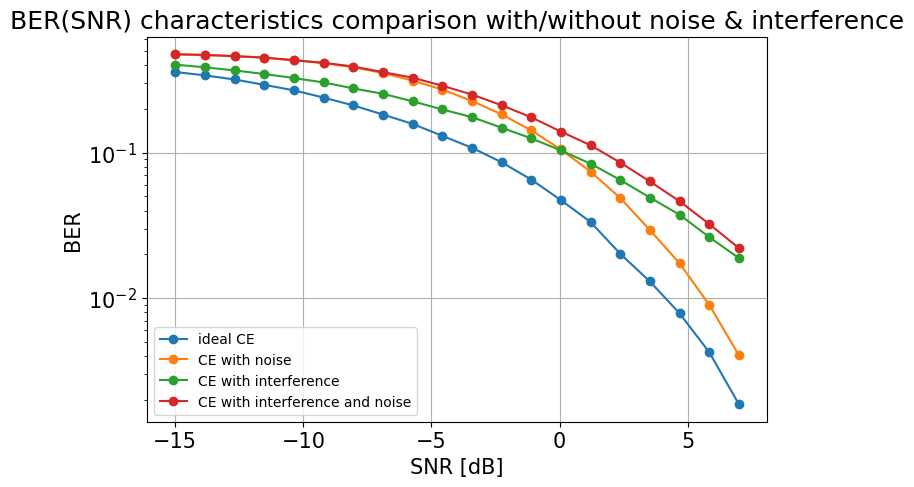

In [61]:
# plot results (example)
plt.figure(figsize = (8,5))
plt.plot(snr_range, ber_ideal[0], 'o-', label = 'ideal CE')
plt.plot(snr_range, ber_noisy[0], 'o-', label = 'CE with noise')
plt.plot(snr_range, ber_interf[0], 'o-', label = 'CE with interference')
plt.plot(snr_range, ber_interf_noise[0], 'o-', label = 'CE with interference and noise')


plt.yscale('log')
plt.grid()
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.title('BER(SNR) characteristics comparison with/without noise & interference')
plt.legend(fontsize = 10, loc = 'lower left')
plt.show()

Мы видим, что неидеальная оценка канала приводит к ухудшению производительности, что означает, что наш прекодер пытается сконцентрировать передаваемую мощность на ложных направлениях (что происходит из-за шума). Можно ли улучшить неидеальную CE? Конечно, и мы воспользуемся свойствами импульсной характеристики канала, которые вы исследовали в начале этой задачи.

Давайте вернемся к импульсной характеристике канала. В начале задачи мы зафиксировали пару антенн. Однако наличие нескольких антенн позволяет нам лучше оценить целевой сигнал. Если мы предположим, что UE находится в дальней зоне, то мы можем предположить, что каждая антенна BS измеряет канал с одинаковыми задержками, поэтому мы можем усреднить CIR вдоль оси антенны, чтобы лучше оценить сигнал

In [62]:
def mean_CIR(x):
    '''
    Calculates CIR meaned along antennas
    INPUTS:
        - x: (np.ndarray) chanel with shape of [N_ue_ants x N_bs_ants x N_subcarriers]
    OUTPUTS:
        - 1d CIR with shape of N_subcarriers, meaned along N_ue_ants and N_bs_ants
    '''

    X = ifft(x, axis = -1, norm = 'ortho') # Transfrom from frequency domain into time domain
    X = ifftshift(X, axes = -1)            # Move zero bin into the middle
    X_abs = np.abs(X)                      # Amplitude of delay spectrum
    X_mean = np.mean(X_abs, (0,1))         # Mean Amplitude along antenna space
    return X_mean


### Let us compare ideal and noisy channels
# obtain CE without noise
y_target = receiver_signal(H_UL_t[:,target_ue],
                           srs_signal[target_srs],
                           SNR_dB = None)
H_est_UL = LS_channel_est(y_target, srs_signal[target_srs].flatten())
H_est_DL_ideal = H_est_UL.swapaxes(0,1).conj()  # Ideal DL channel estimation


# obtain CE with noise
y_target = receiver_signal(H_UL_t[:,target_ue],
                           srs_signal[target_srs],
                           SNR_dB = -10)
H_est_UL = LS_channel_est(y_target, srs_signal[target_srs].flatten())
H_est_DL_noisy = H_est_UL.swapaxes(0,1).conj()  # Noisy DL channel estimation


# obtain CE of interfered channel without noise
y_interf = receiver_signal(H_UL_t_interf[:,interf_ue],
                           srs_signal[interf_srs],
                           SNR_dB = None)

H_est_UL = LS_channel_est(y_target + y_interf, srs_signal[target_srs].flatten())
H_est_DL_noisy_interf = H_est_UL.swapaxes(0,1).conj()

# calcuate CIRs meaned over antenna space
cir_ideal = mean_CIR(H_est_DL_ideal)
cir_noisy = mean_CIR(H_est_DL_noisy)
cir_noisy_interf = mean_CIR(H_est_DL_noisy_interf)

Из рисунка видно, что мы хотели бы получить только несколько отсчётов целевого сигнала, амплитуда которых больше, чем у шума. Это можно сделать, применив простую функцию жесткого окна в области задержки, которая выбирает только отсчёты внутри окна.
Вам нужно реализовать такой оконный фильтр и исследовать, как ширина влияет на кривую BER, если наш предполагаемый канал получен с шумом, помехами, шумом и помехами. Сформулируйте стратегию выбора оптимальной длины окна.

(288,)


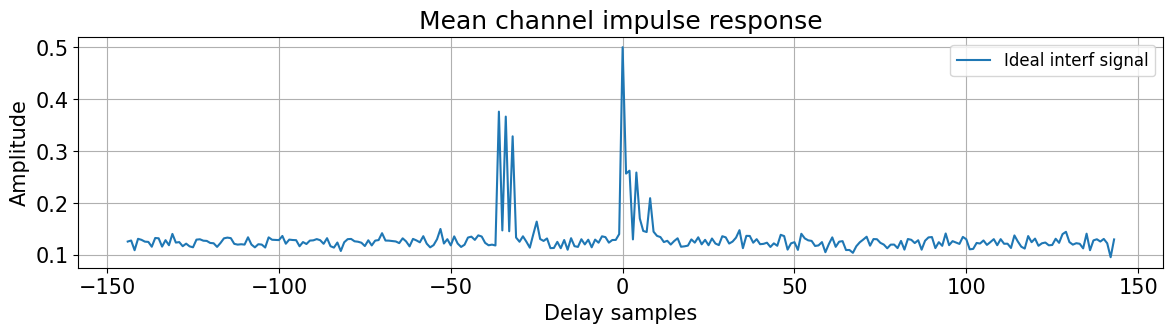

In [63]:
plt.figure(figsize=(14,3))
# plt.plot(get_dft_axis(cir_ideal), cir_ideal, label = 'Ideal target signal')
# plt.plot(get_dft_axis(cir_noisy), cir_noisy, label = 'Noisy target signal')
plt.plot(get_dft_axis(cir_noisy_interf), cir_noisy_interf, label = 'Ideal interf signal')
wind_example = np.zeros_like(cir_ideal)
print(cir_ideal.shape)
wind_example[:20] = 1
# plt.plot(get_dft_axis(wind_example), wind_example, label = 'Some window function')
# plt.fill_between(get_dft_axis(wind_example), wind_example, 0, color='red', alpha =0.2)

plt.title('Mean channel impulse response')
plt.xlabel('Delay samples')
plt.ylabel('Amplitude')
plt.grid()
plt.legend(fontsize = 12)
plt.show()

In [64]:
showed = False

In [65]:
def window_filter(H_est, window):
    '''
    Applies window filter in the delay domain
    INPUTS:
        - H_est: (np.ndarray) estimated DL channel with shape of [N_ue_ants x N_bs_ants x N_subcarriers]
        - window: (Any) paramenters of the window which you would like to define
    '''
    N_ue, N_bs_ants, N_delays = H_est.shape

    # Your code here
    # ---------------------------------------------------------------------------------------
    #   Transfrom signal from frequency domain into delay domain
    h_imp = ifft(H_est, axis=-1)
    # mean_values = np.mean(np.abs(h_imp[0]), axis=0)
    # plt.plot(mean_values)
    # plt.show()

    #   Calculate and apply window filter
    h_imp = np.multiply(h_imp, window)
    # mean_values = np.mean(np.abs(h_imp[0]), axis=0)
    # plt.plot(mean_values)
    # plt.show()

    #   Transform back from delay domain into frequency domain
    H_filtered = fft(h_imp)

    # ---------------------------------------------------------------------------------------

    return H_filtered

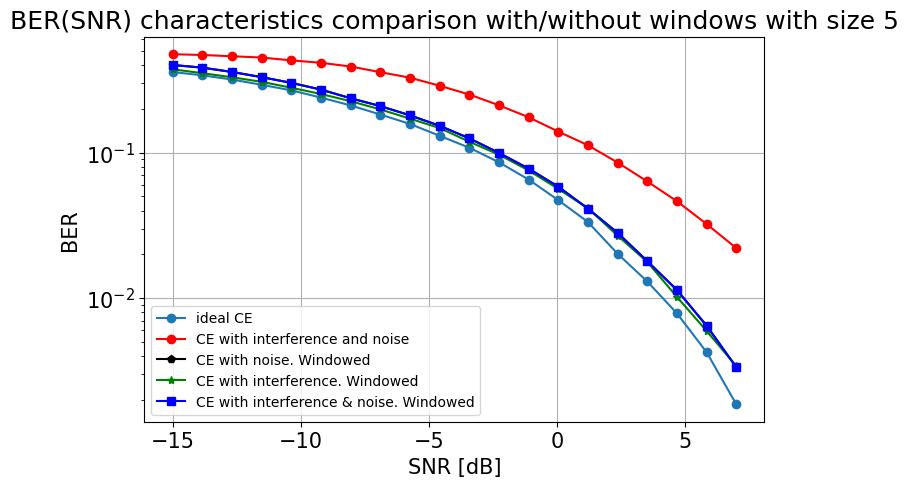

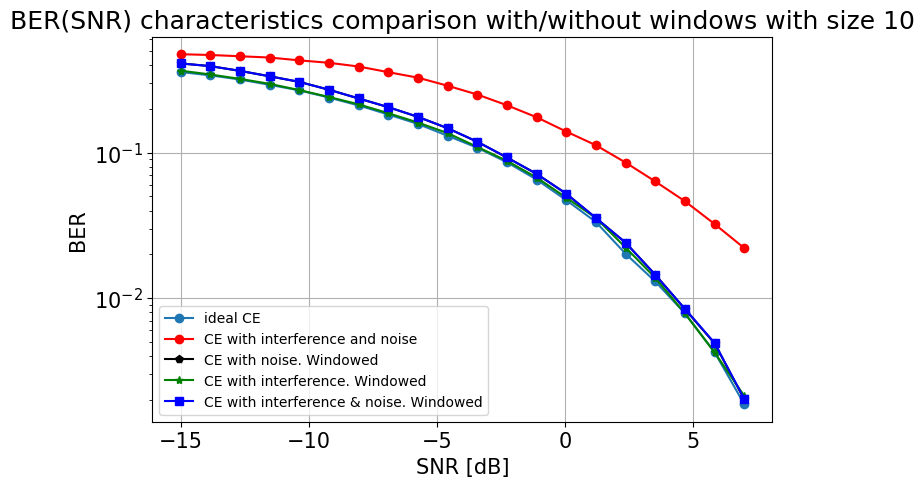

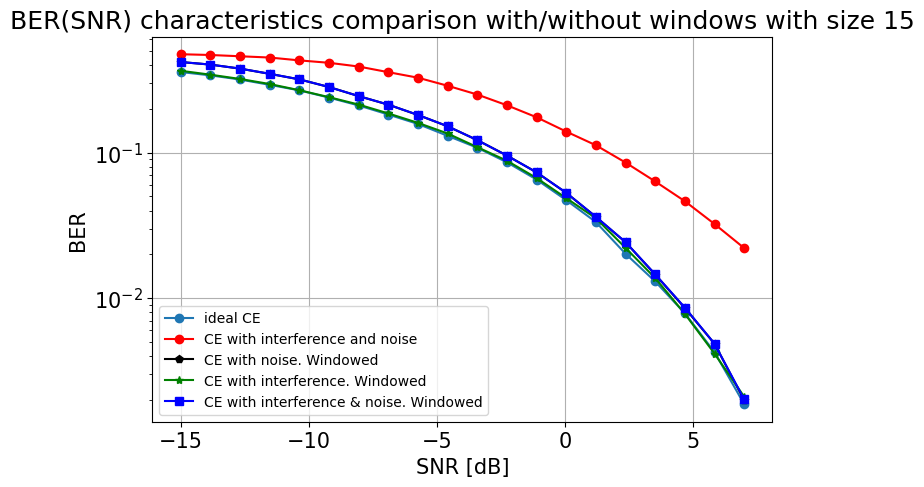

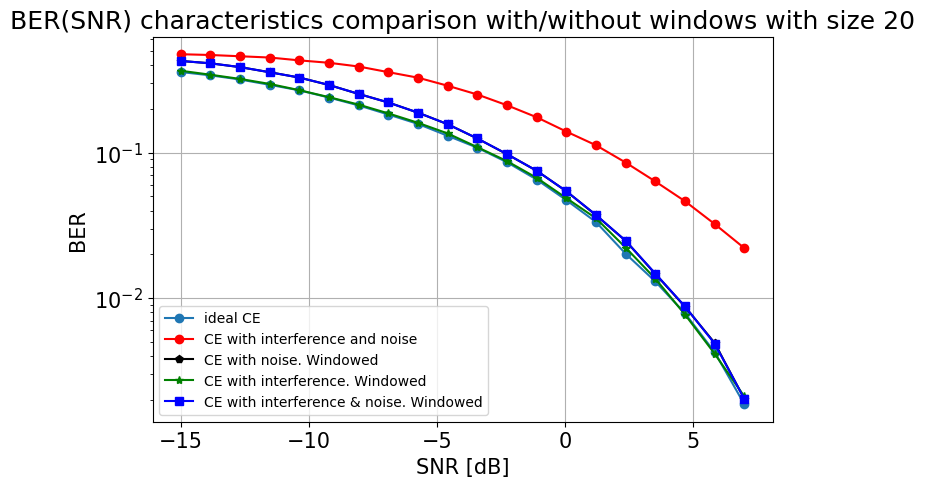

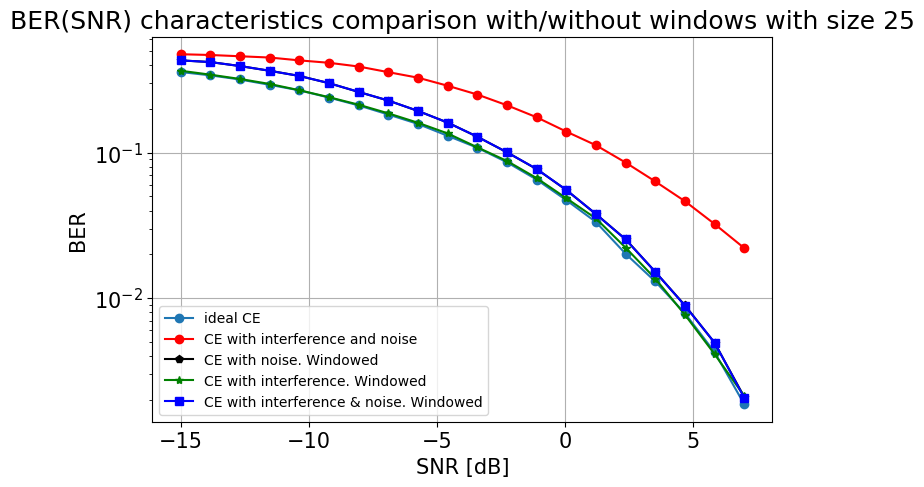

In [66]:
import multiprocessing

# Simulations with window filter
# ---------------------------------------------------------------------------------------
# Your code here
for window_size in range(5, 30, 5):
    window = np.zeros(srs_subcarriers.shape)
    window_start = int(srs_subcarriers.shape[0] / 2)
    window[window_start:window_start + window_size] = 1

    arguments = [(snr_range, "svd", window, True, False),
                 (snr_range, "svd", window, False, True),
                 (snr_range, "svd", window, True, True)]

    ber_noisy_window = None
    ber_interf_window = None
    ber_interf_noise_window = None

    with multiprocessing.Pool() as pool:
        for result in pool.starmap(send_experiment_with_channel_approx, arguments):
            if (ber_noisy_window is None):
                ber_noisy_window = result
            elif (ber_interf_window is None):
                ber_interf_window = result
            else:
                ber_interf_noise_window = result
    # ber_noisy_window =  send_experiment_with_channel_approx(snr_range, "svd", 
    #                         window, noise_uplink_flag=True, interfere_flag=False)
    # ber_interf_window =  send_experiment_with_channel_approx(snr_range, "svd",
    #                         window, noise_uplink_flag=False, interfere_flag=True)
    # ber_interf_noise_window = send_experiment_with_channel_approx(snr_range, "svd",
    #                         window, noise_uplink_flag=True, interfere_flag=True)
    
    plt.figure(figsize = (8,5))
    plt.plot(snr_range, ber_ideal[0], 'o-', label = 'ideal CE')
    plt.plot(snr_range, ber_interf_noise[0], 'o-', label = 'CE with interference and noise', color = 'red')
    plt.plot(snr_range, ber_noisy_window[0], 'p-',color = 'black', label = 'CE with noise. Windowed')
    plt.plot(snr_range, ber_interf_window[0], '*-',color = 'green', label = 'CE with interference. Windowed')
    plt.plot(snr_range, ber_interf_noise_window[0], 's-',color = 'blue', label = 'CE with interference & noise. Windowed')


    plt.yscale('log')
    plt.grid()
    plt.xlabel('SNR [dB]')
    plt.ylabel('BER')
    plt.title(f'BER(SNR) characteristics comparison with/without windows with size {window_size}')
    plt.legend(fontsize = 10, loc = 'lower left')
    plt.show()

# ---------------------------------------------------------------------------------------